In [1]:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import SparsePCA, PCA
from sklearn.base import clone
import os
import pandas as pd

# Import all models
from sklearn.ensemble import IsolationForest
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.lscp import LSCP
%matplotlib inline
data_loc = '/media/gabriel/storage/dipet/csv_concat'
network_file = "state_all_network.csv"

In [2]:
def load_filter_low_variance(data_loc,
                             network_file,
                             low_varaince=True):
    """
    :param data_loc: directory where files are located
    :param network_file: name of the csv to be loaded
    :return:
    """
    print("Data location: ")
    print(data_loc)
    print("Work dir")
    print(os.getcwd())
    print("Checking files in data location ...")
    df_network = pd.read_csv(os.path.join(data_loc, network_file))
    df_work = df_network
    if low_varaince:
        #Get unique columns
        from collections import Counter
        items = Counter(df_network).keys()
        print("Unique column size: {}".format(items))
        print(f"Columns found: {df_network.columns}")

        print("Checking low variance columns ...")
        print("Starting Clean dataset")
        uniques = df_work.apply(lambda x: x.nunique())
        rm_columns = []
        for uindex, uvalue in uniques.iteritems():
            if uvalue == 1:
                rm_columns.append(uindex)
        print("First pass columns to be removed")
        print(rm_columns)
        # Remove common low variance columns
        df_work.drop(rm_columns, inplace=True, axis=1)
    print("Shape after low varince drop")
    print(df_work.shape)
    return df_work

def filter_columns_wildcard(df_work, wild_card):
    """
    :param wild_card: str wildcard of columns to be filtered
    :return:
    """
    filter_col_wildcard = wild_card
    filtr_list = []
    mask = df_work.columns.str.contains(filter_col_wildcard)
    filtr_list.extend(list(df_work.loc[:,mask].columns.values))
    print("Columns to be filtered:")
    print(filtr_list)
    df_concat_filtered = df_work[filtr_list]

    print("Columns of filtered data:")
    print(df_concat_filtered.columns)
    return df_concat_filtered

def filter_nan_col(df_concat_filtered,
                   drop_threashold=0.4,
                   verbose=0):
    """
    :param drop_threashold: threashold for dropping columns based on NaN values
    :return:
    """
    # Count nan values per column and set drop threashold
    drop_list_th = []
    for c in df_concat_filtered.columns.values:
        percentage_nan = 100*df_concat_filtered[c].isna().sum()/len(df_concat_filtered)
        if verbose:
            print(f"Length of column {c} is {len(df_concat_filtered)}")
            print(f"Of which {df_concat_filtered[c].isna().sum()} are nan")
            print(f"Percentage of nan in {c} is {percentage_nan}")
        if percentage_nan > drop_threashold:
            # print(f"Percentage of nan in {c} is {percentage_nan}")
            drop_list_th.append(c)
    print(f"Colsumns before nan drop: {df_concat_filtered.shape[-1]}")
    print(f"Columns to be droped {len(drop_list_th)}")
    # print(drop_list_th)
    # print(df_concat_filtered.columns)
    df_concat_filtered.drop(drop_list_th, axis=1, inplace=True)

def decision_boundary(clf,
                      data,
                      anomaly_label = -1,
                      model_name = "Not defined"):
    """
    :param clf: model to be refitted with 2 features (PCA)
    :param data: dataset after PCA
    :param anomaly_label: label for anomaly instances (differs from method to method)
    :param model_name: name of the model to be displayed
    :return:
    """

    # fit model
    clf.set_params(max_features=data.shape[-1]) # becouse we have only two features we must override previous setting
    clf.fit(data)
    y_pred_outliers = clf.predict(data)

    # get anomaly index
    anomaly_index_rf = np.where(y_pred_outliers==anomaly_label)
    # Get anomalies based on index
    ano_rf = data[anomaly_index_rf]
    # plot the line, the samples, and the nearest vectors to the plane
    xx, yy = np.meshgrid(np.linspace(-80, 80, 80), np.linspace(-80, 80, 80))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.title(model_name)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
    b1 = plt.scatter(data[:, 0], data[:, 1], c='white',
                 s=20, edgecolor='k')
    c = plt.scatter(ano_rf[:, 0], ano_rf[:, 1], c='red',
                s=20, edgecolor='k')
    plt.axis('tight')
    plt.xlim((-50, 80))
    plt.ylim((-5, 80))
    plt.legend([b1, c],
           ["normal",
            "anomaly",],
           loc="upper left")
    plt.show()

def plot_on_features(data, pred, anomay_label=-1):
    """
    :param data: dataset used for training or prediction
    :param pred: model prediction
    :param anomay_label: label for anomaly instances (differs from method to method)
    :return:
    """
    col_names_plt = list(data.columns.values)
    data['anomaly'] = pred
    for feature in col_names_plt:
        if feature == 'epoch' or feature == 'anomaly':
            pass
        else:
            # fig, ax = plt.subplots(figsize=(15,10))
            a = data[data['anomaly'] == anomay_label] #anomaly
            _ = plt.figure(figsize=(18,6))
            _ = plt.plot(data[feature], color='blue', label='Normal')
            _ = plt.plot(a[feature], linestyle='none', marker='X', color='red', markersize=4, label='Anomaly')
            _ = plt.xlabel('Date and Time')
            _ = plt.ylabel(f'{feature}')
            _ = plt.title(f'{feature} Anomalies')
            _ = plt.legend(loc='best')
            plt.show();

def plot_feature_sep(data, pred, anomaly_label=-1, normal_label=1):
    """
    :param data: dataset used for training or prediction
    :param pred: model prediction
    :param anomaly_label: label for anomaly instances (differs from method to method)
    :param normal_label:
    :return:
    """
    col_names_plt = list(data.columns.values)
    data['anomaly'] = pred
    for feature in col_names_plt:
        if feature == 'epoch' or feature == 'anomaly' or feature == 'id':
            pass
        else:
            normal_event = data.loc[data['anomaly'] == normal_label, feature]
            anomay_event = data.loc[data['anomaly'] == anomaly_label, feature]

            plt.figure(figsize=(10, 6))
            plt.hist(normal_event, bins = 50, alpha=0.5, density=True,label='{} normal'.format(feature))
            plt.hist(anomay_event, bins = 50, alpha=0.5, density=True, label='{} anomaly'.format(feature))
            plt.legend(loc='upper right')
            plt.xlabel(feature)
            plt.ylabel('Count')
            plt.show();

In [3]:
df_work = load_filter_low_variance(data_loc, network_file)

Data location: 
/media/gabriel/storage/dipet/csv_concat
Work dir
/home/gabriel/Research/Dipet/exp
Checking files in data location ...
Unique column size: dict_keys(['ctxt.rate_0', 'eth.txe.rate_0', 'eth.rxe.rate_0', 'eth.txb.rate_0', 'eth.rxb.rate_0', 'eth.txp.rate_0', 'eth.rxp.rate_0', 'wifi.txe.rate_0', 'wifi.rxe.rate_0', 'wifi.txb.rate_0', 'wifi.rxb.rate_0', 'wifi.txp.rate_0', 'wifi.rxp.rate_0', 'ctxt.rate_1', 'eth.txe.rate_1', 'eth.rxe.rate_1', 'eth.txb.rate_1', 'eth.rxb.rate_1', 'eth.txp.rate_1', 'eth.rxp.rate_1', 'wifi.txe.rate_1', 'wifi.rxe.rate_1', 'wifi.txb.rate_1', 'wifi.rxb.rate_1', 'wifi.txp.rate_1', 'wifi.rxp.rate_1', 'ctxt.rate_2', 'eth.txe.rate_2', 'eth.rxe.rate_2', 'eth.txb.rate_2', 'eth.rxb.rate_2', 'eth.txp.rate_2', 'eth.rxp.rate_2', 'wifi.txe.rate_2', 'wifi.rxe.rate_2', 'wifi.txb.rate_2', 'wifi.rxb.rate_2', 'wifi.txp.rate_2', 'wifi.rxp.rate_2', 'ctxt.rate_3', 'eth.txe.rate_3', 'eth.rxe.rate_3', 'eth.txb.rate_3', 'eth.rxb.rate_3', 'eth.txp.rate_3', 'eth.rxp.rate_3', '

In [6]:
df_concat_filtered = filter_columns_wildcard(df_work, 'x')

Columns to be filtered:
['ctxt.rate_0', 'eth.txb.rate_0', 'eth.rxb.rate_0', 'eth.txp.rate_0', 'eth.rxp.rate_0', 'wifi.txb.rate_0', 'wifi.rxb.rate_0', 'wifi.txp.rate_0', 'wifi.rxp.rate_0', 'ctxt.rate_1', 'wifi.txb.rate_1', 'wifi.rxb.rate_1', 'wifi.txp.rate_1', 'wifi.rxp.rate_1', 'ctxt.rate_2', 'eth.txb.rate_2', 'eth.rxb.rate_2', 'eth.txp.rate_2', 'eth.rxp.rate_2', 'wifi.txb.rate_2', 'wifi.rxb.rate_2', 'wifi.txp.rate_2', 'wifi.rxp.rate_2', 'ctxt.rate_3', 'eth.txb.rate_3', 'eth.txp.rate_3', 'wifi.txb.rate_3', 'wifi.rxb.rate_3', 'wifi.txp.rate_3', 'wifi.rxp.rate_3', 'ctxt.rate_4', 'eth.txb.rate_4', 'eth.rxb.rate_4', 'eth.txp.rate_4', 'eth.rxp.rate_4', 'wifi.txb.rate_4', 'wifi.rxb.rate_4', 'wifi.txp.rate_4', 'wifi.rxp.rate_4', 'ctxt.rate_5', 'eth.txb.rate_5', 'eth.rxb.rate_5', 'eth.txp.rate_5', 'eth.rxp.rate_5', 'wifi.txb.rate_5', 'wifi.rxb.rate_5', 'wifi.txp.rate_5', 'wifi.rxp.rate_5', 'ctxt.rate_6', 'wifi.rxb.rate_6', 'wifi.rxp.rate_6', 'wifi.txb.rate_6', 'wifi.txp.rate_6', 'ctxt.rate_7',

In [7]:
filter_nan_col(df_concat_filtered, drop_threashold=0.4)

Colsumns before nan drop: 541
Columns to be droped 453


In [8]:
# Fill nan values
df_concat_filtered.fillna(value=0, inplace=True)

In [9]:
# Delete rows with nan
# df_concat_filtered.drop(df_concat_filtered[df_concat_filtered['ctxt.rate_0']==0].index, inplace=True)
# df_concat_filtered.loc[df_concat_filtered['ctxt.rate_0'] == 0]
# df_concat_filtered

In [10]:
# Scaling Data
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = StandardScaler()
# scaler = RobustScaler
scaler.fit(df_concat_filtered)
scaled = scaler.transform(df_concat_filtered)

# Scaled data back to df from np.array
df_concat_filtered_scaled = pd.DataFrame(scaled, index=df_concat_filtered.index, columns=df_concat_filtered.columns)
df_concat_filtered_scaled

ctxt.rate_7  eth.txb.rate_7  eth.rxb.rate_7  eth.txp.rate_7  \
0         1.155952        1.501347        0.339453        1.038400   
1         1.625753        0.569324        0.614119        0.656299   
2         0.765943        0.502984        0.375698        0.608034   
3         0.166620       -0.263969       -0.379723       -0.230125   
4        -0.037070       -0.343531       -0.414702       -0.349993   
...            ...             ...             ...             ...   
94393     0.901002       -0.209683       -0.351573       -0.329365   
94394     1.084845       -0.252686       -0.364711       -0.310867   
94395     0.865088       -0.352416       -0.459760       -0.418073   
94396     1.008247       -0.326956       -0.455808       -0.430832   
94397     0.872064       -0.293854       -0.423187       -0.406796   

       eth.rxp.rate_7  ctxt.rate_10  eth.txb.rate_10  eth.rxb.rate_10  \
0            0.863031     -1.229544        -0.343244        -0.265597   
1            0.572385     -0.726588        -0.335625         0.068151   
2            0.477539     -0.642999        -0.249682        -0.168402   
3           -0.300966     -0.966199        -0.263307        -0.409633   
4           -0.396446     -0.767371        -0.342214        -0.408779   
...               ...           ...              ...              ...   
94393       -0.423227     -3.385351        -0.369359        -0.443789   
94394       -0.380973     -3.385351        -0.369359        -0.443789   
94395       -0.479384     -3.385351        -0.369359        -0.443789   
94396       -0.491830     -3.385351        -0.369359        -0.443789   
94397       -0.470417     -3.385351        -0.369359        -0.443789   

       eth.txp.rate_10  eth.rxp.rate_10  ...  eth.rxp.rate_63  ctxt.rate_66  \
0            -0.407187        -0.298306  ...        -0.271407      0.205737   
1            -0.233431        -0.045341  ...        -0.248128      0.266193   
2            -0.286942        -0.193768  ...        -0.274333      0.024321   
3            -0.380580        -0.425103  ...        -0.279421      0.622985   
4            -0.458587        -0.437738  ...        -0.295449      0.423005   
...                ...              ...  ...              ...           ...   
94393        -0.546079        -0.710489  ...        -0.533576     -3.557265   
94394        -0.546079        -0.710489  ...        -0.533576     -3.557265   
94395        -0.546079        -0.710489  ...        -0.533576     -3.557265   
94396        -0.546079        -0.710489  ...        -0.533576     -3.557265   
94397        -0.546079        -0.710489  ...        -0.533576     -3.557265   

       eth.txb.rate_66  eth.rxb.rate_66  eth.txp.rate_66  eth.rxp.rate_66  \
0            -0.509802        -0.754957        -0.685048        -0.777962   
1            -0.240858        -0.657059        -0.502013        -0.674948   
2            -0.593435        -0.756526        -0.733154        -0.798150   
3            -0.592711        -0.755766        -0.734837        -0.797523   
4            -0.518997        -0.756075        -0.694188        -0.786351   
...                ...              ...              ...              ...   
94393        -0.609348        -0.760264        -0.771201        -0.819929   
94394        -0.609348        -0.760264        -0.771201        -0.819929   
94395        -0.609348        -0.760264        -0.771201        -0.819929   
94396        -0.609348        -0.760264        -0.771201        -0.819929   
94397        -0.609348        -0.760264        -0.771201        -0.819929   

       wifi.txb.rate_66  wifi.rxb.rate_66  wifi.txp.rate_66  wifi.rxp.rate_66  
0             -0.722536         -0.077010         -0.727342         -0.577336  
1             -0.461625         -0.515988         -0.543604         -0.553504  
2             -0.727120         -0.572337         -0.790976         -0.781898  
3             -0.725183         -0.555134         -0.786309         -0.786190  
4             -

Anomalies in dataset of size 94398 found: 472
Anomalies2 in dataset of size 94398 found: 472
Initial shape: (94398, 88)
PCA data shape: (94398, 2)


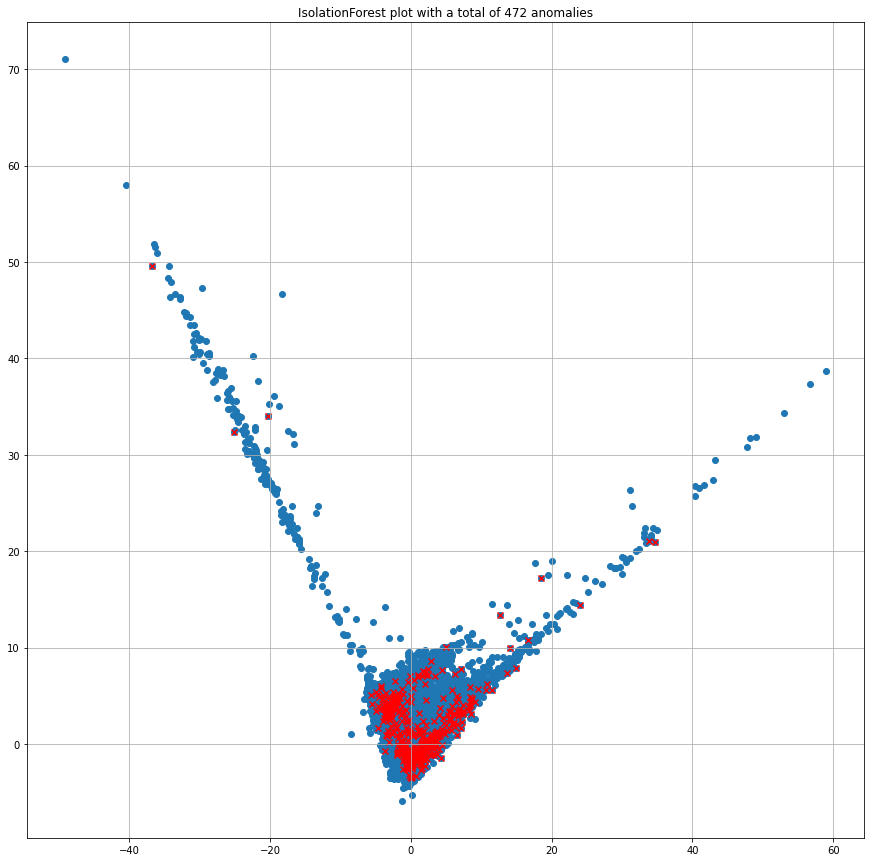

In [11]:
dataset_rf = df_concat_filtered_scaled
dataset_raw = df_concat_filtered_scaled
contamination = 0.005
max_features = 8
# contamination = "auto"
clf_if = IsolationForest(n_estimators=10,
                         warm_start=False,
                         contamination=contamination,
                         max_features=max_features)
clf_clone = clone(clf_if)
clf_if.fit(dataset_rf)
pred = clf_if.predict(dataset_rf)
clf_if.set_params(n_estimators=100)
clf_if.fit(dataset_rf)
pred2 = clf_if.predict(dataset_rf)
print("Anomalies in dataset of size {} found: {}".format(len(list(pred)),list(pred).count(-1)))
print("Anomalies2 in dataset of size {} found: {}".format(len(list(pred2)),list(pred2).count(-1)))

# Get anomaly index and the values based on said index
anomaly_index_rf = np.where(pred==-1)

transformer = PCA(n_components=2)
transformer.fit(dataset_rf)
X_transformed = transformer.transform(dataset_rf)
print("Initial shape: {}".format(dataset_rf.shape))
print("PCA data shape: {}".format(X_transformed.shape))
dataset_rf  = X_transformed

# Get anomalies based on index
values_rf = dataset_rf[anomaly_index_rf]

#Plot prediction on 2d
fig = plt.figure(figsize=(15,15))
plt.scatter(dataset_rf[:,0], dataset_rf[:,1])
plt.scatter(values_rf[:,0], values_rf[:,1], color='r', marker='x')
plt.title("IsolationForest plot with a total of {} anomalies".format(list(pred).count(-1)))
plt.grid()
plt.show()

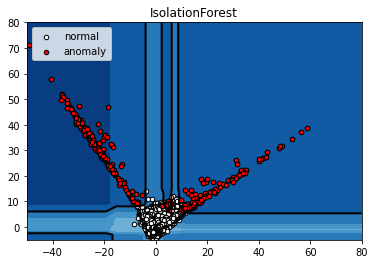

In [12]:

decision_boundary(clf_clone, dataset_rf, model_name="IsolationForest")

(94398, 3)


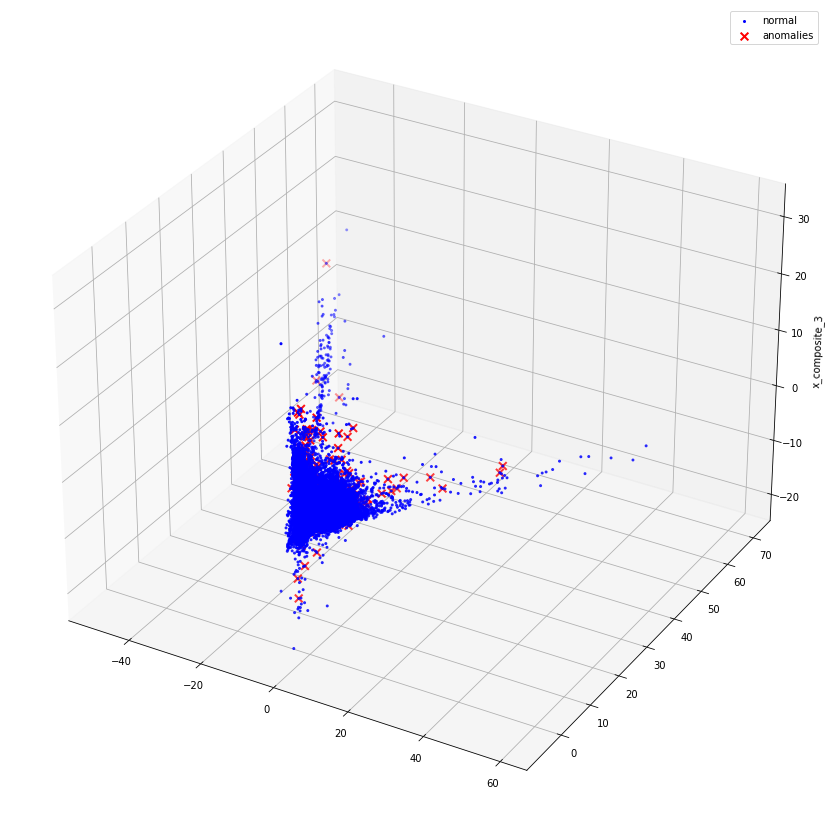

In [13]:
# Data preprocessing options (3d)
transformer = PCA(n_components=3)
transformer.fit(dataset_raw)
X_transformed_3d = transformer.transform(dataset_raw)
print(X_transformed_3d.shape)


# Plot 3D anomaly map
fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_transformed_3d[:, 0], X_transformed_3d[:, 1], zs=X_transformed_3d[:, 2], s=4, lw=1, label="normal",c="blue")
# Plot x's for the ground truth outliers
ax.scatter(X_transformed_3d[anomaly_index_rf,0],X_transformed_3d[anomaly_index_rf,1], X_transformed_3d[anomaly_index_rf,2],
           lw=2, s=60, marker="x", c="red", label="anomalies")
ax.legend()
plt.show()

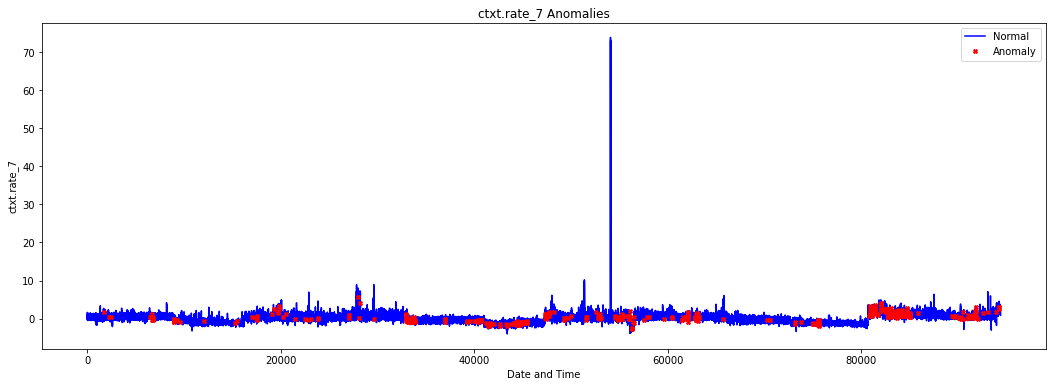

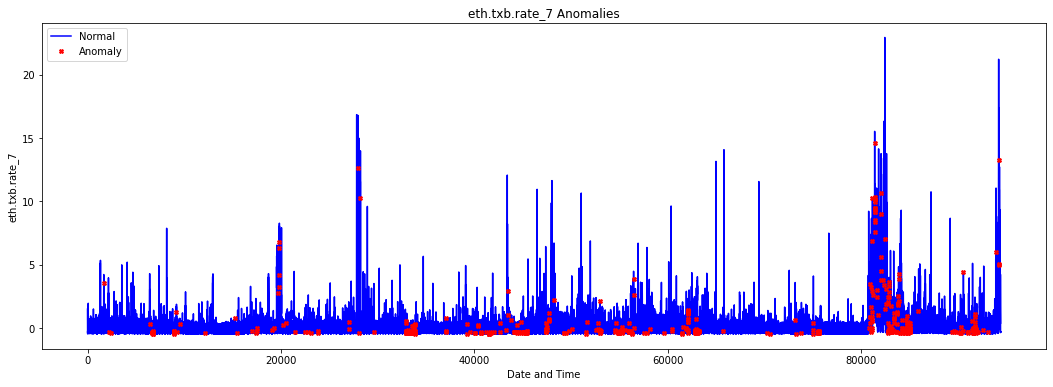

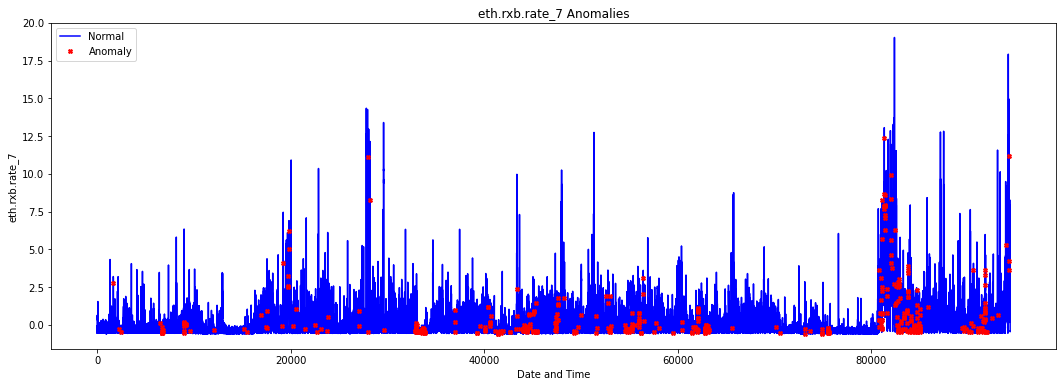

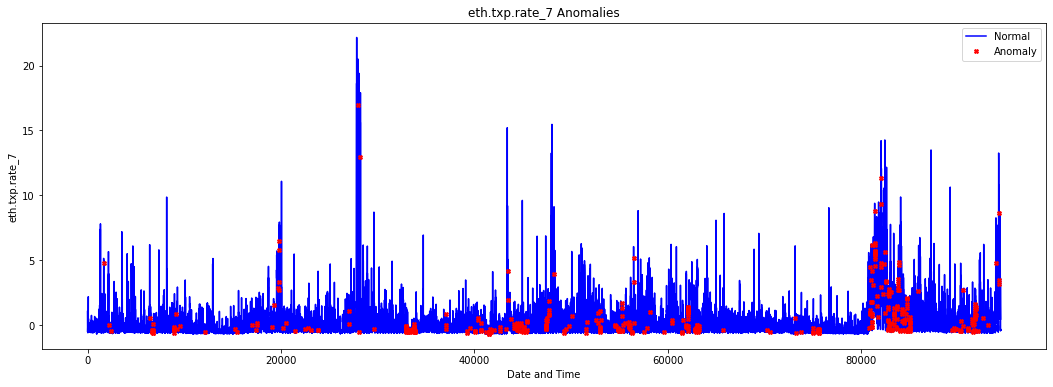

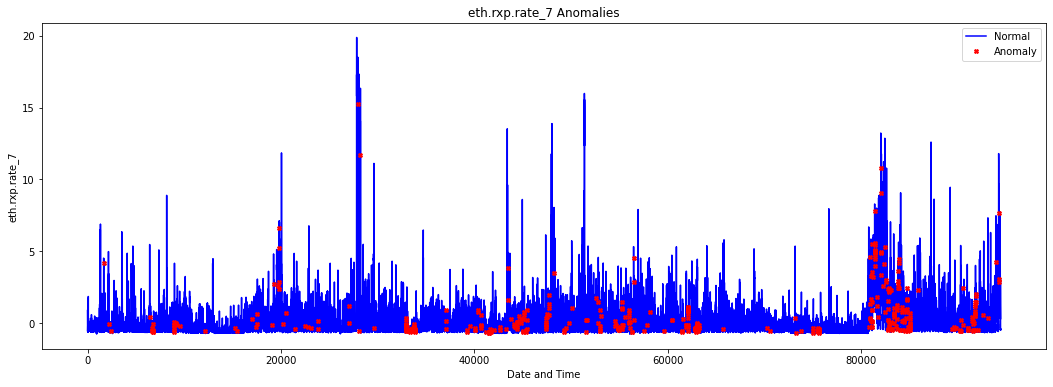

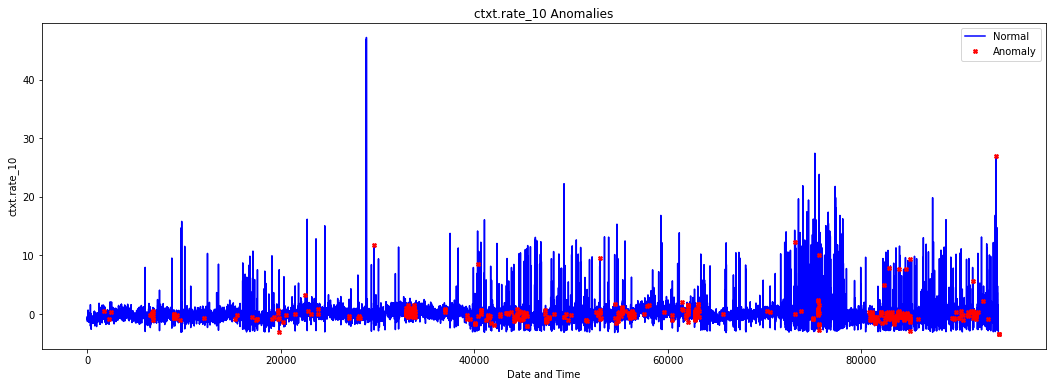

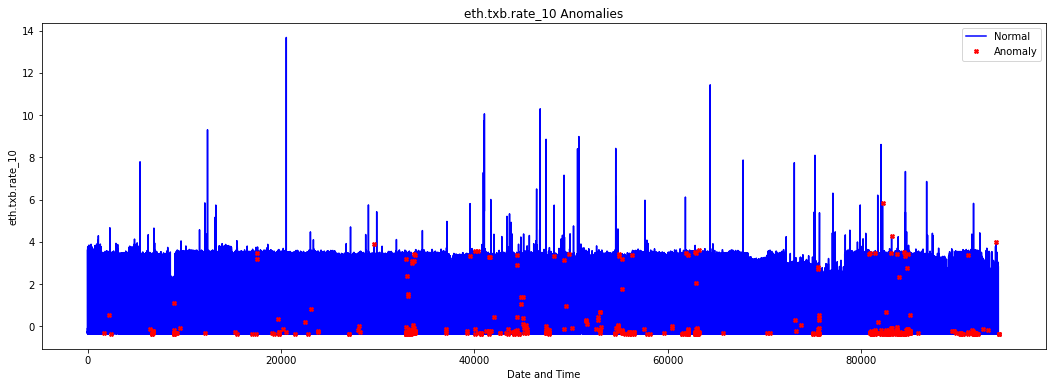

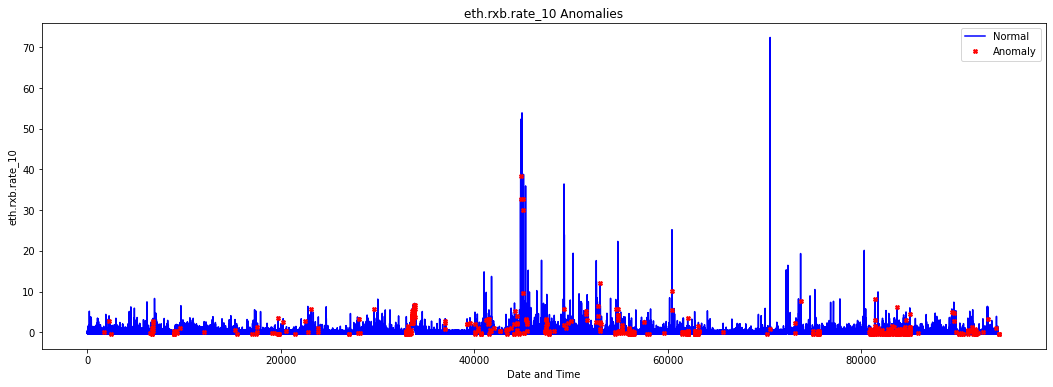

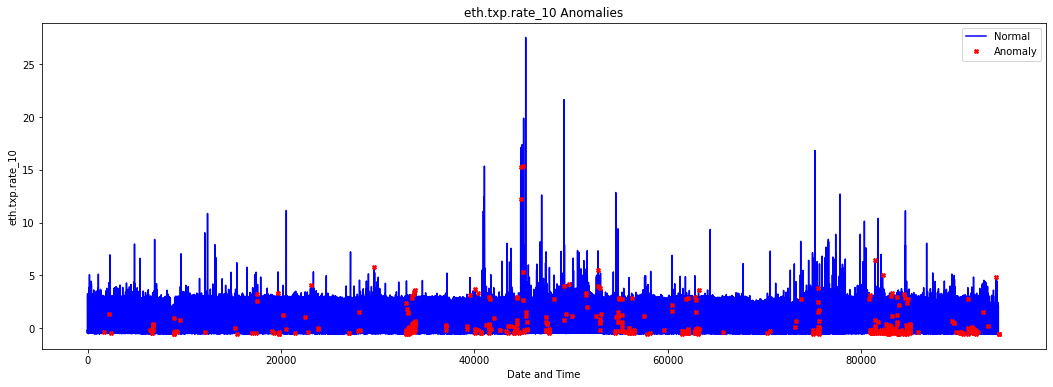

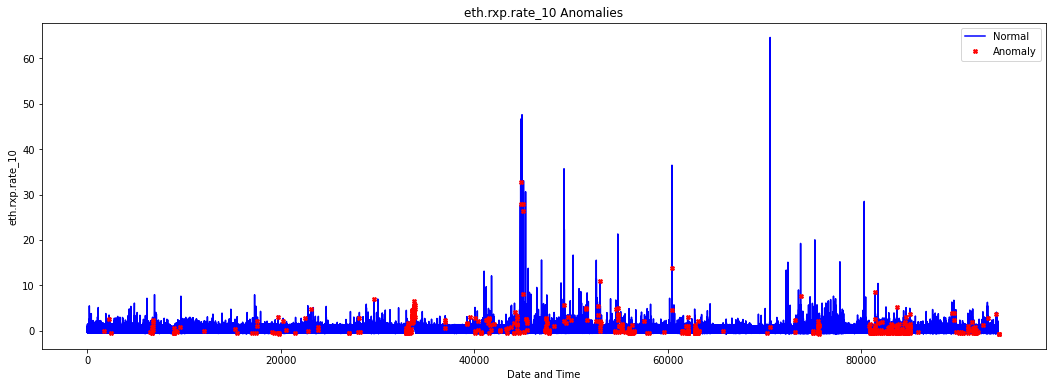

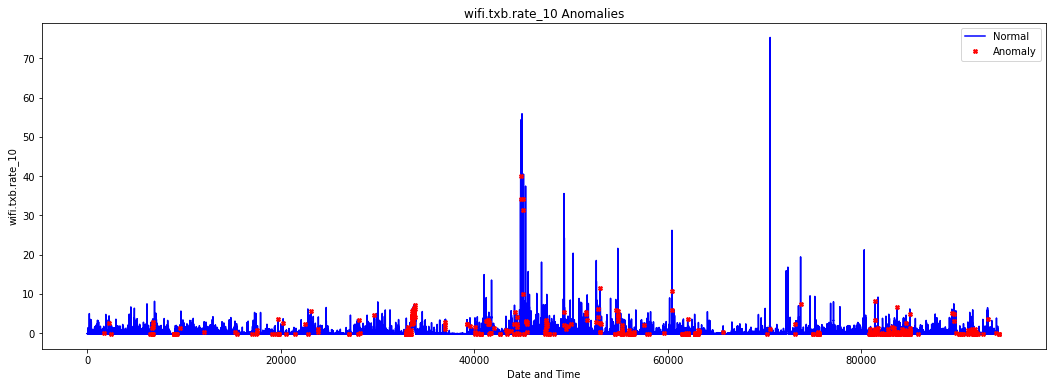

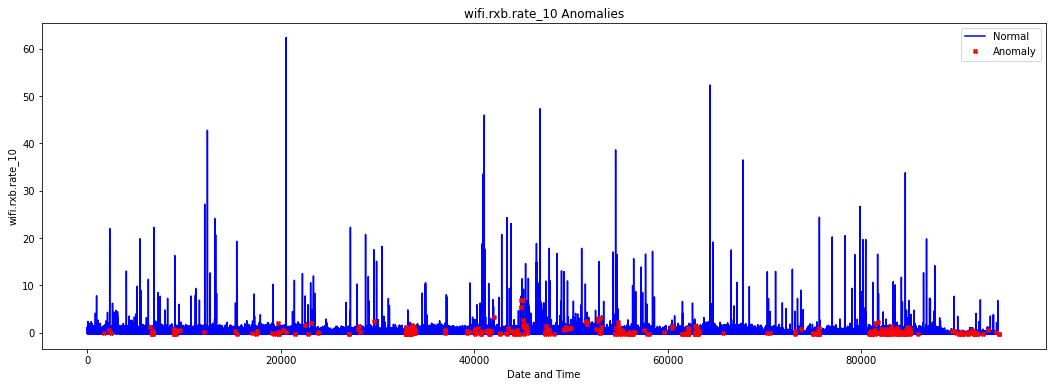

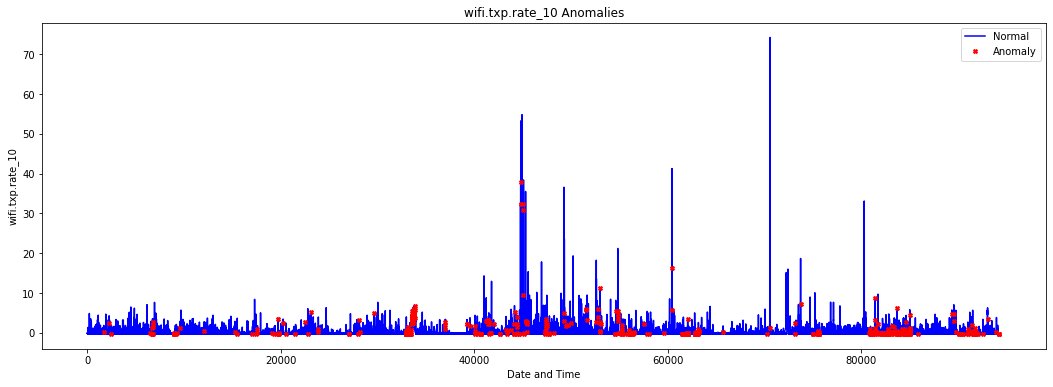

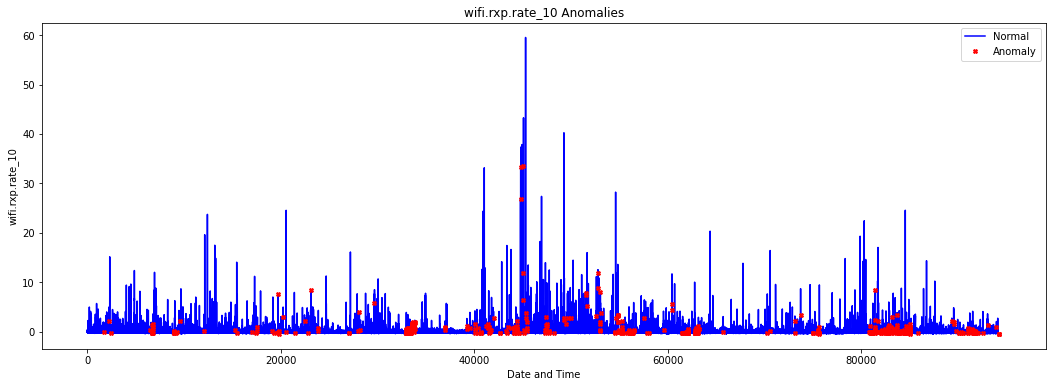

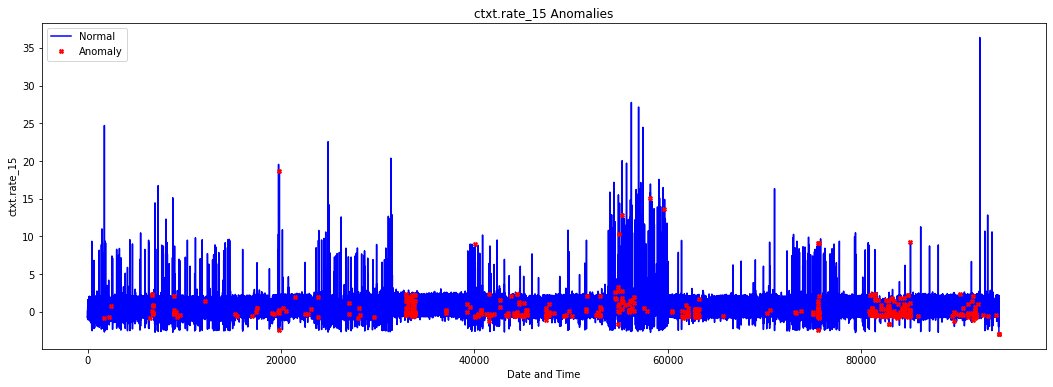

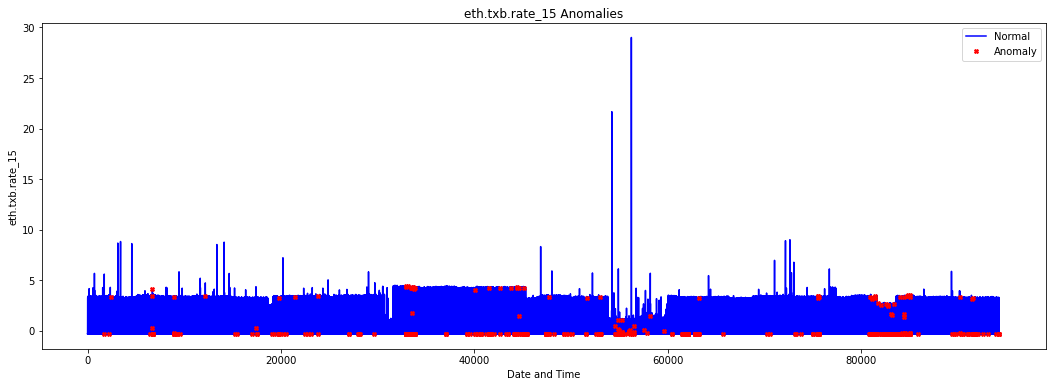

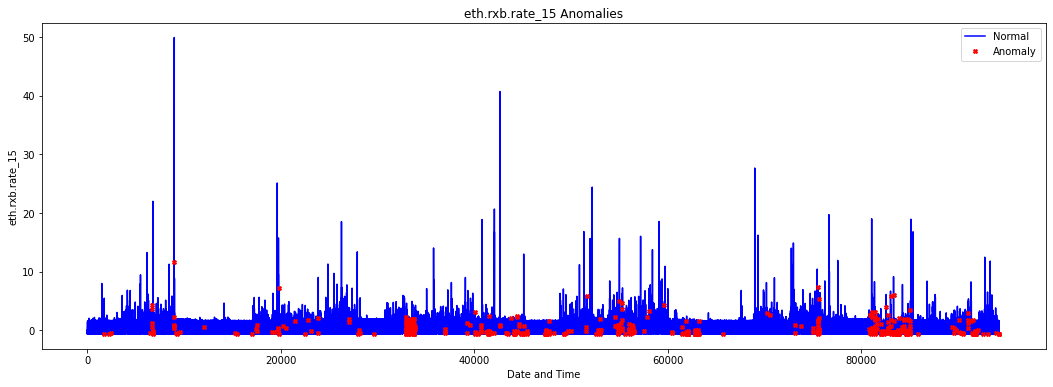

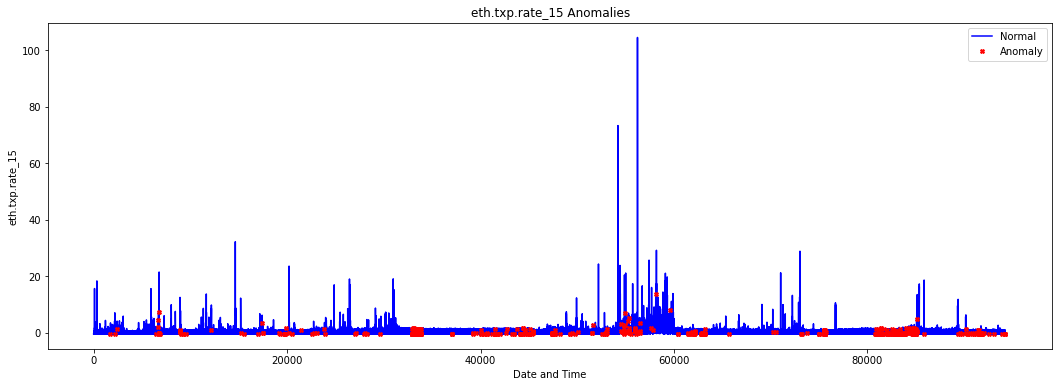

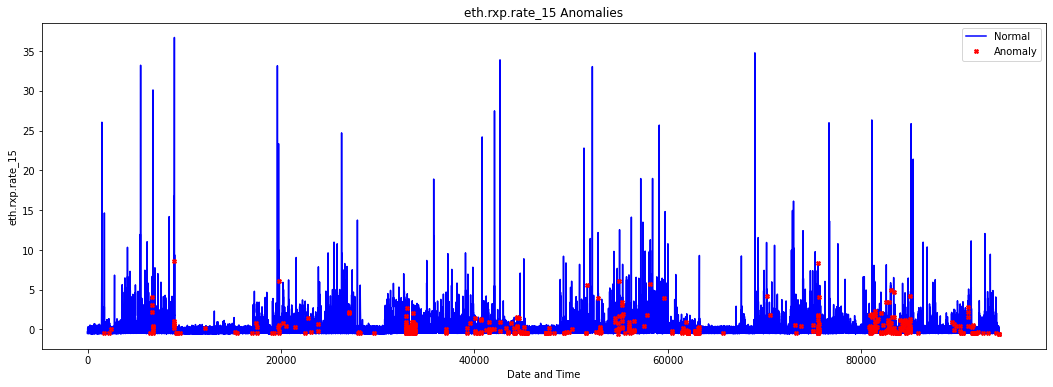

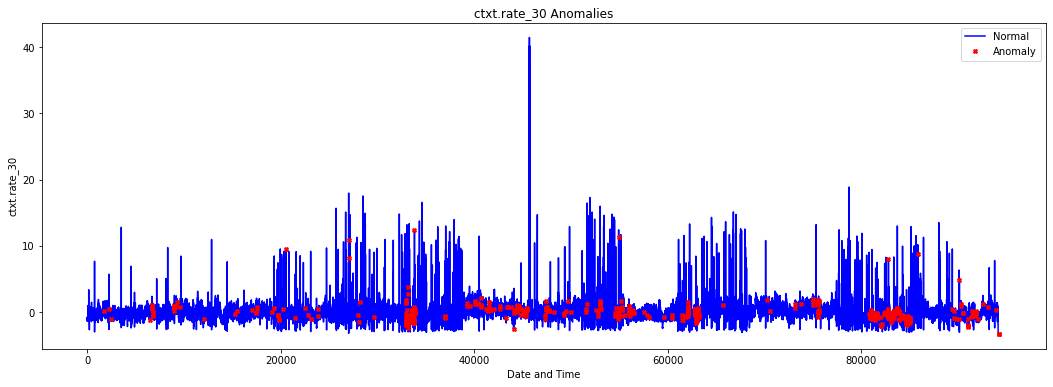

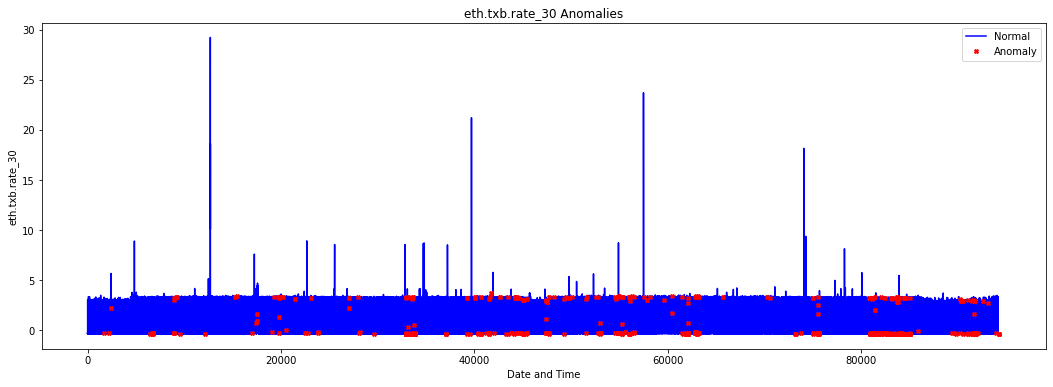

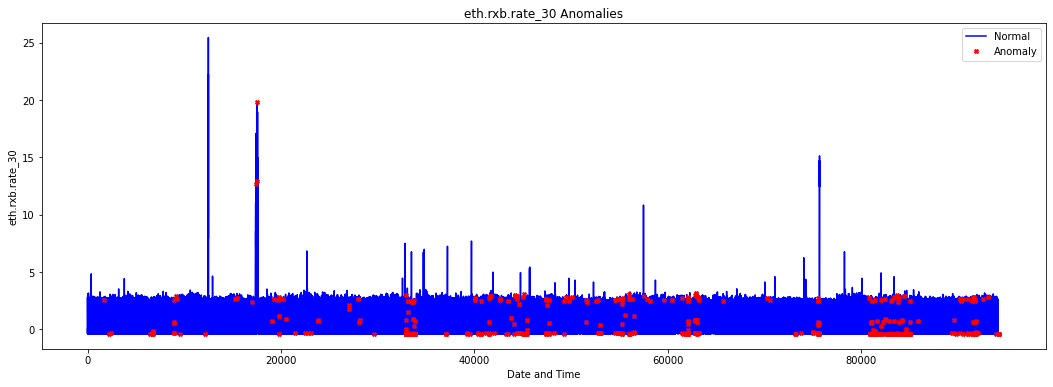

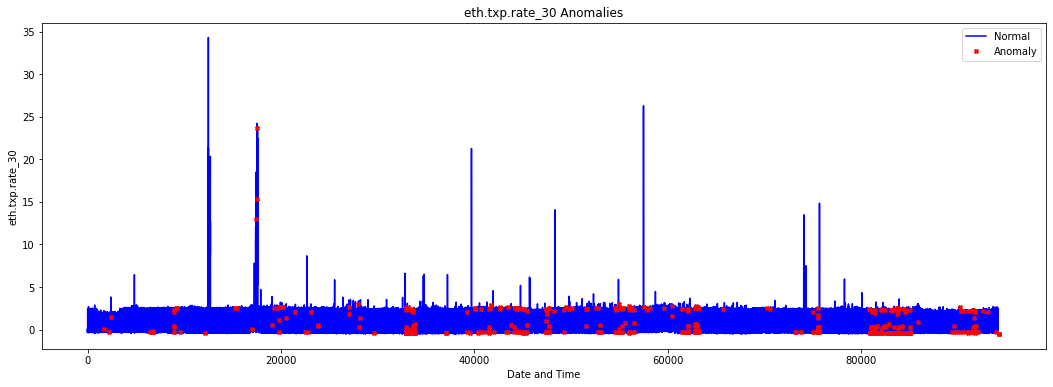

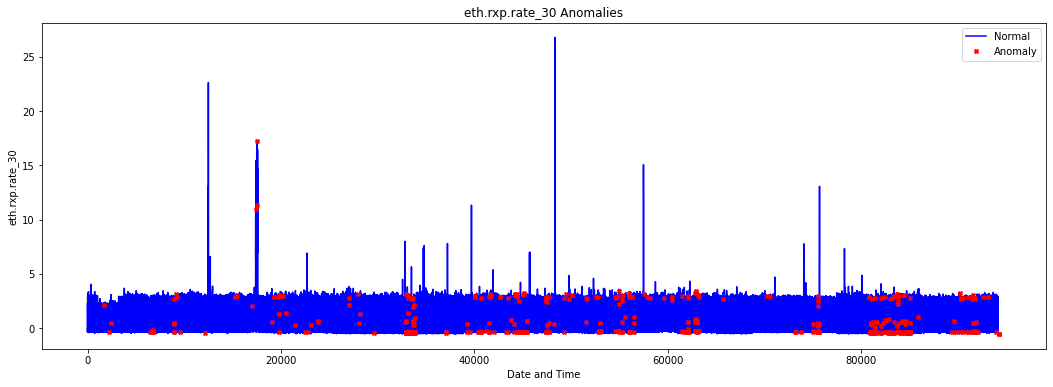

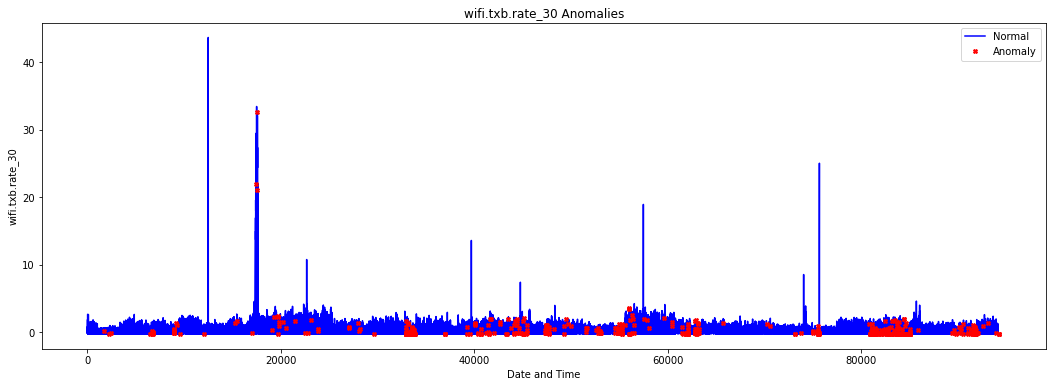

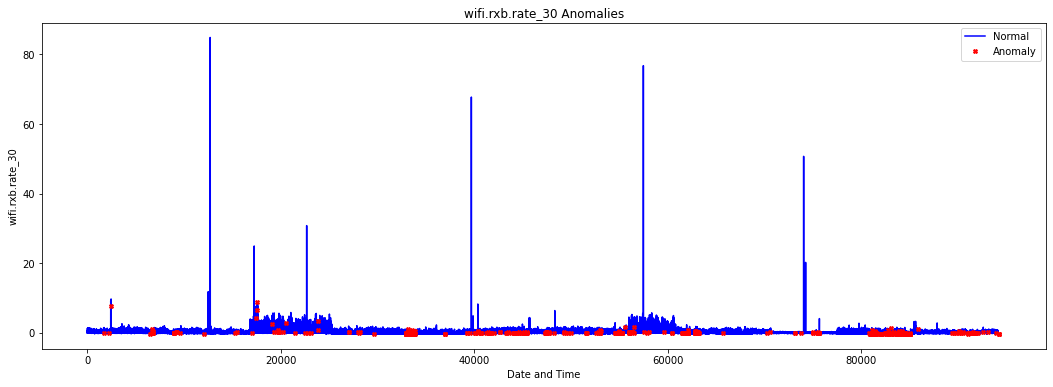

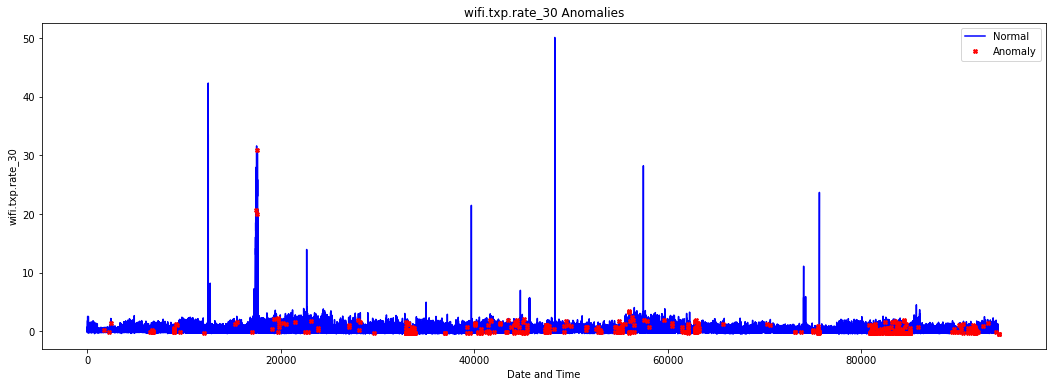

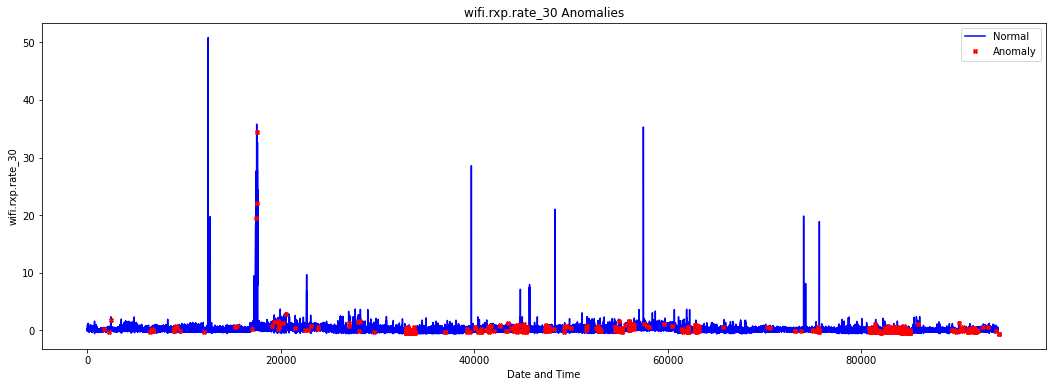

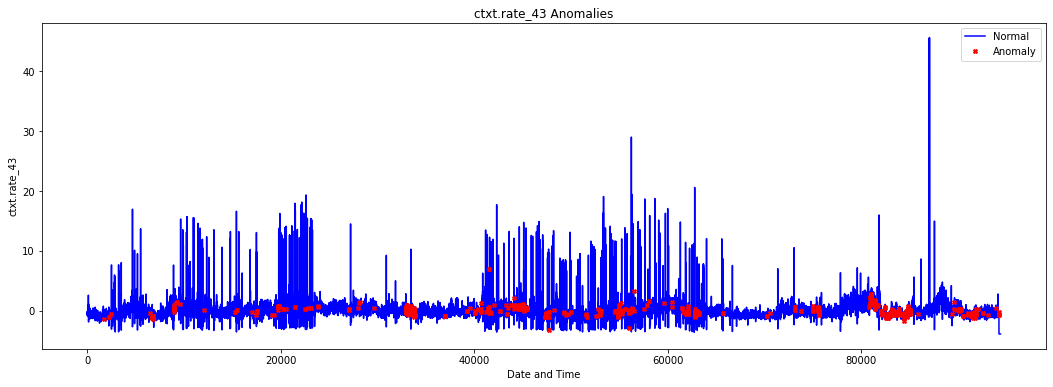

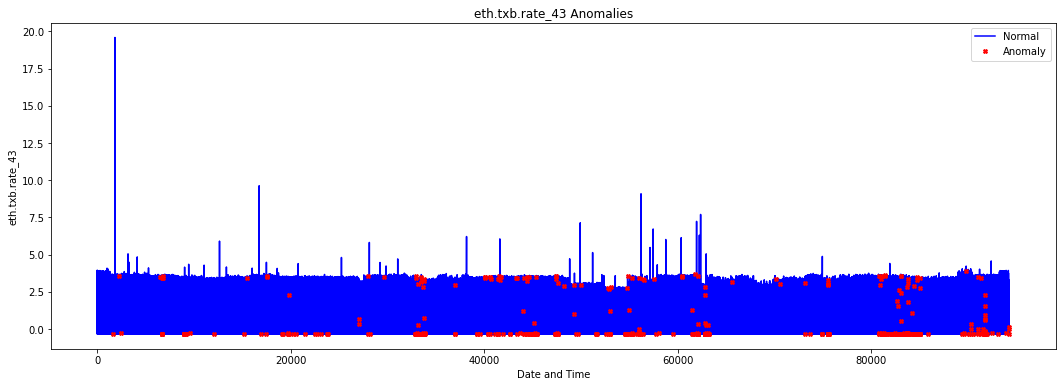

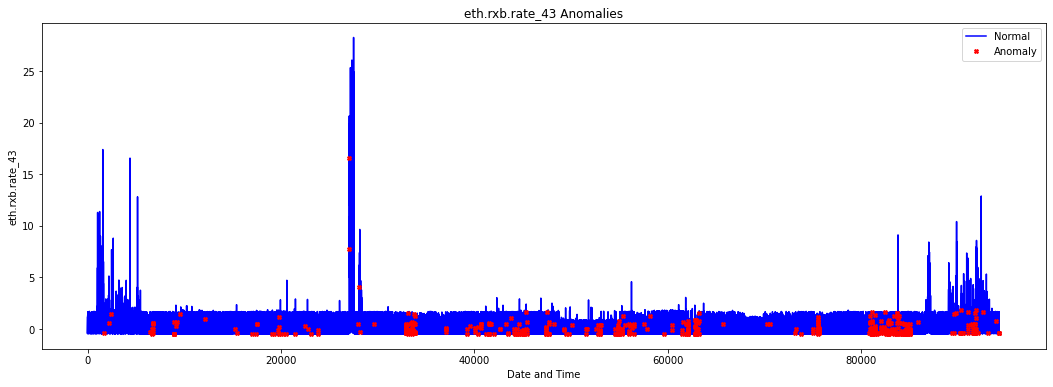

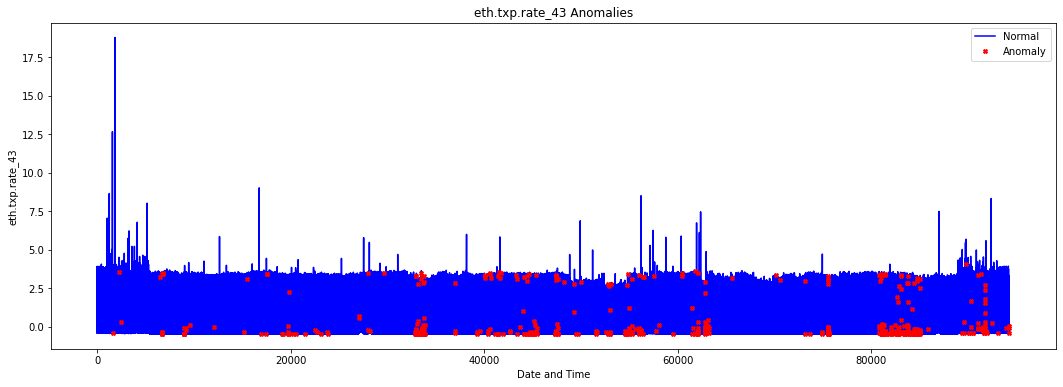

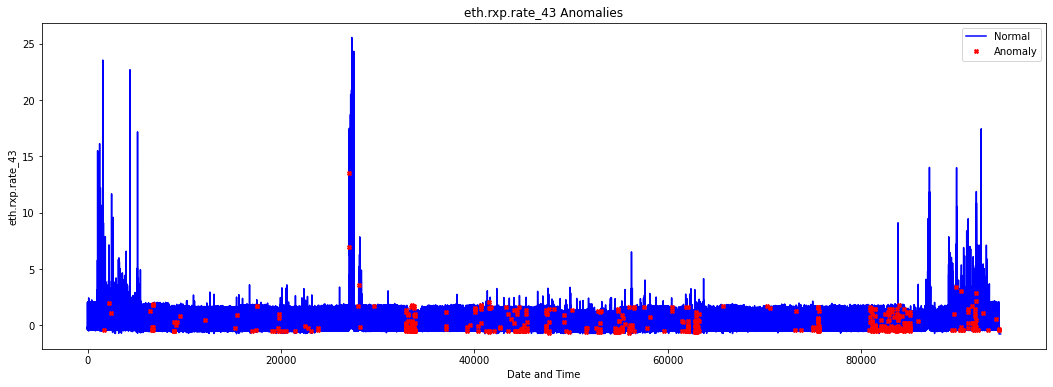

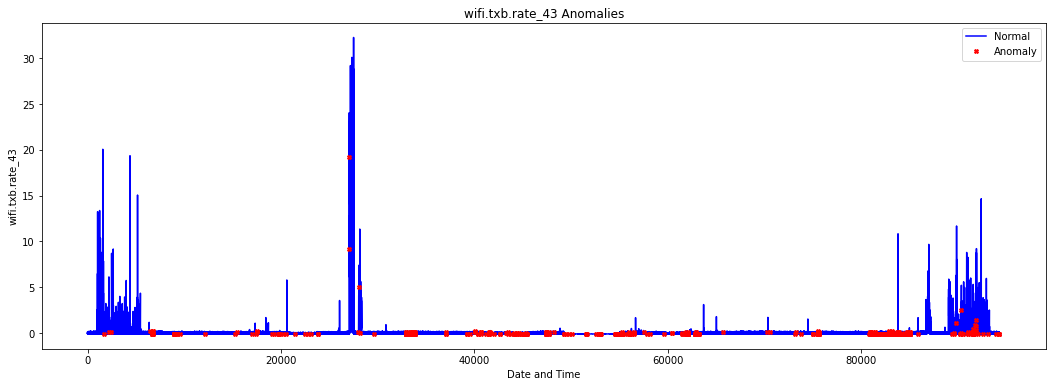

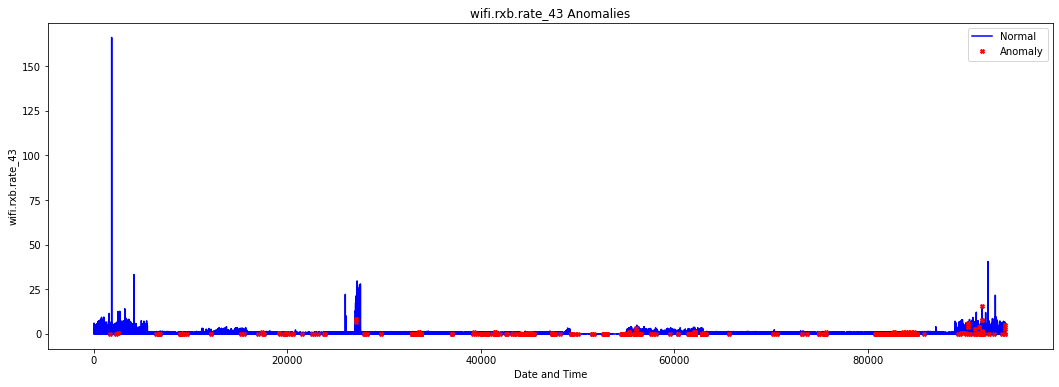

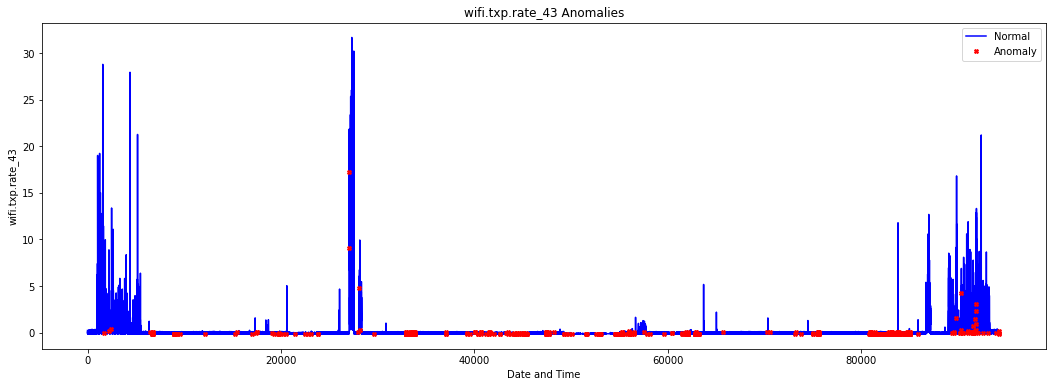

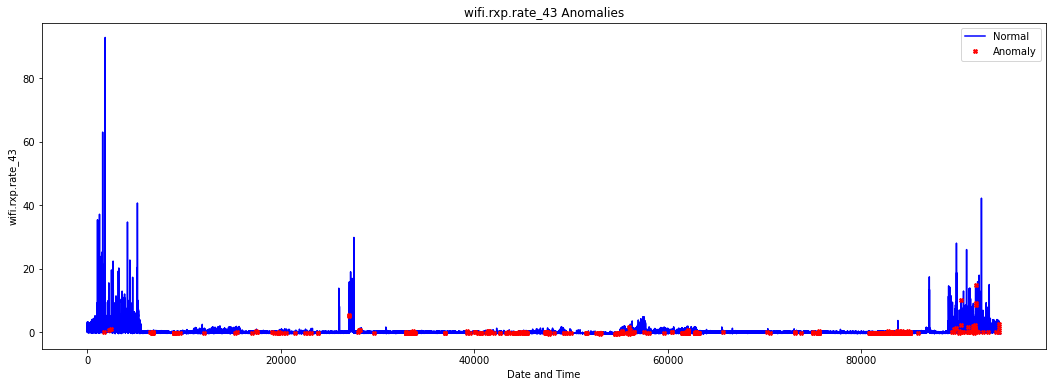

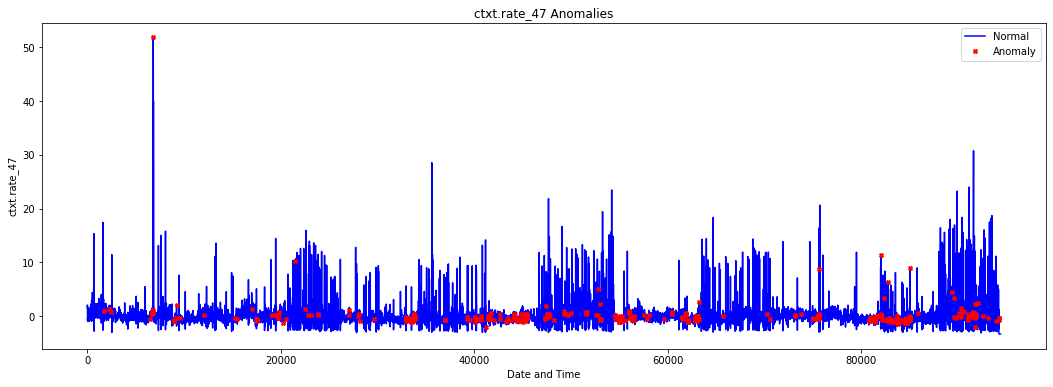

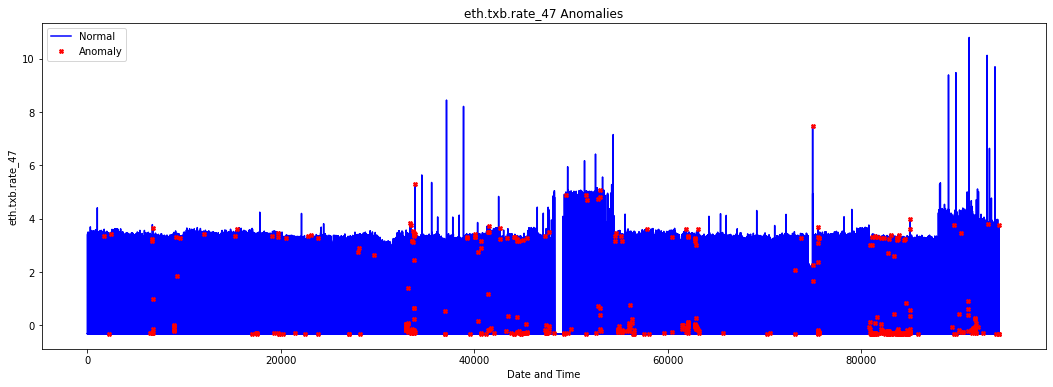

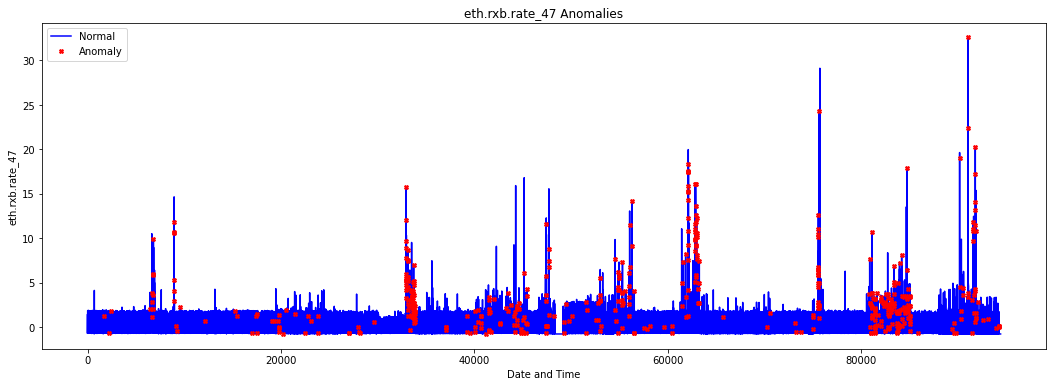

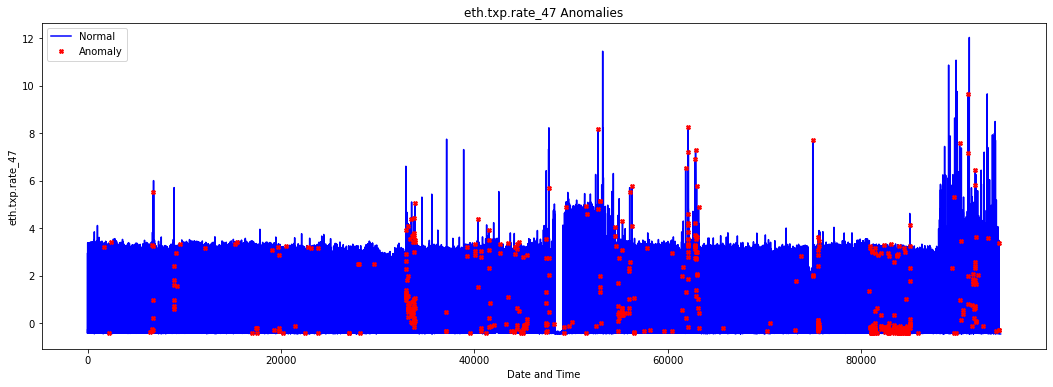

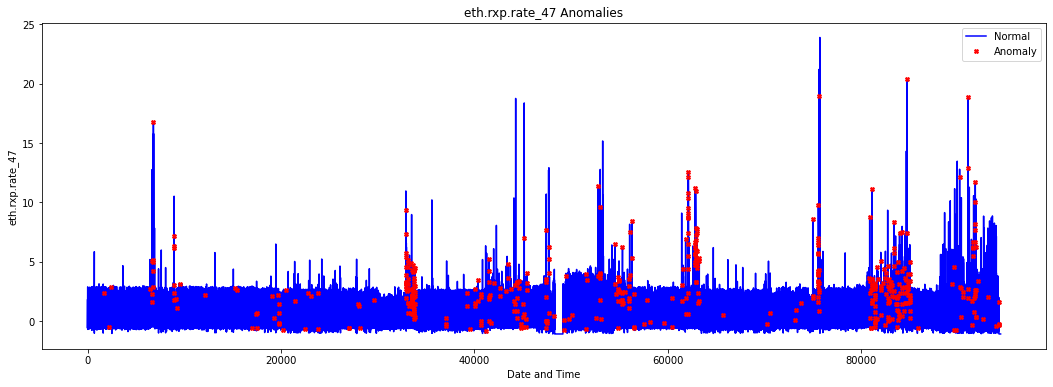

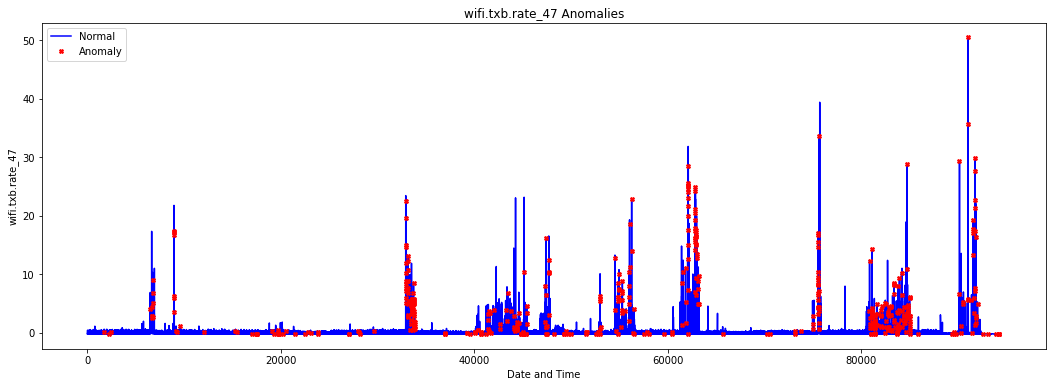

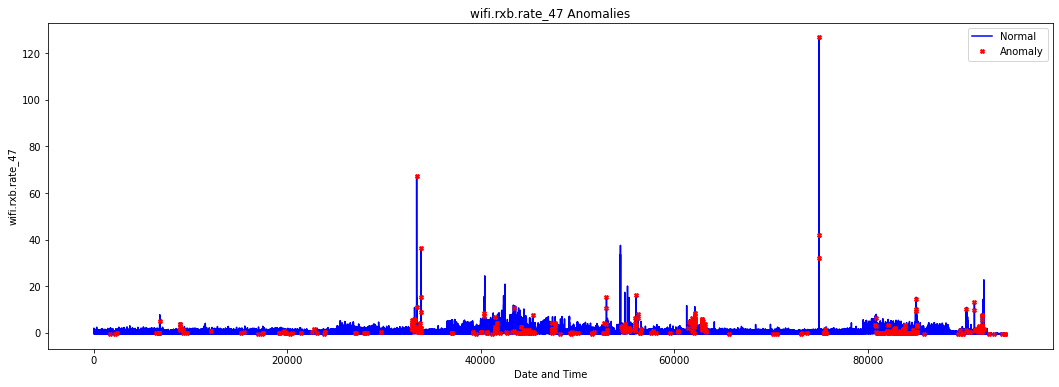

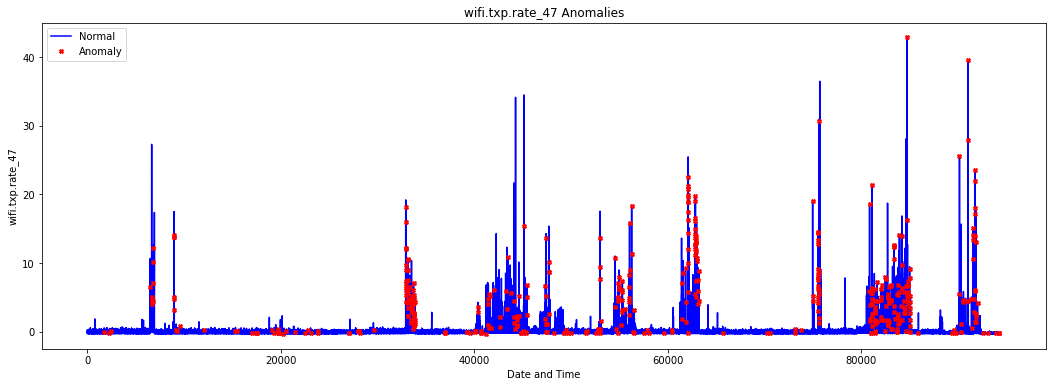

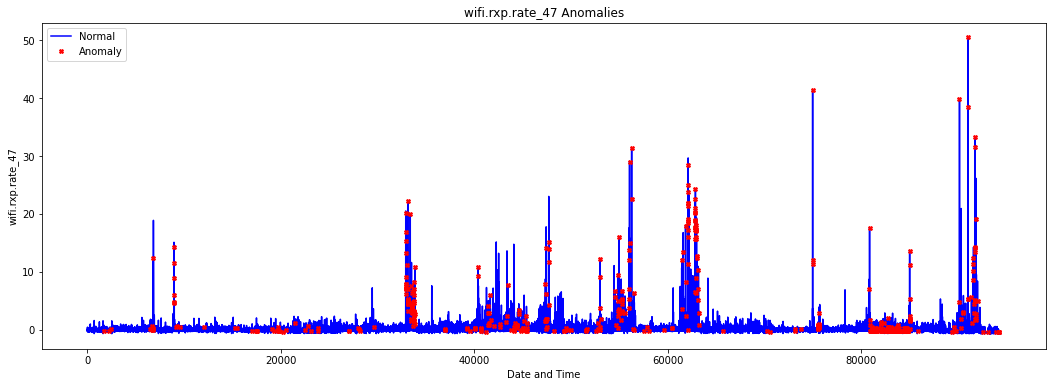

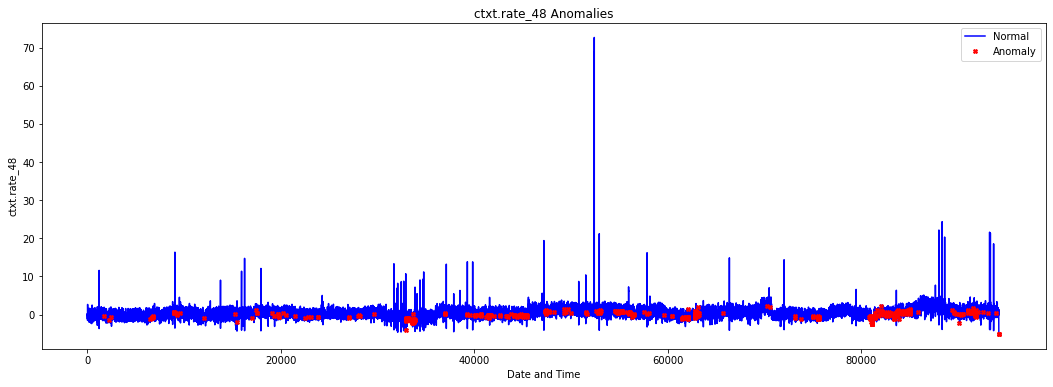

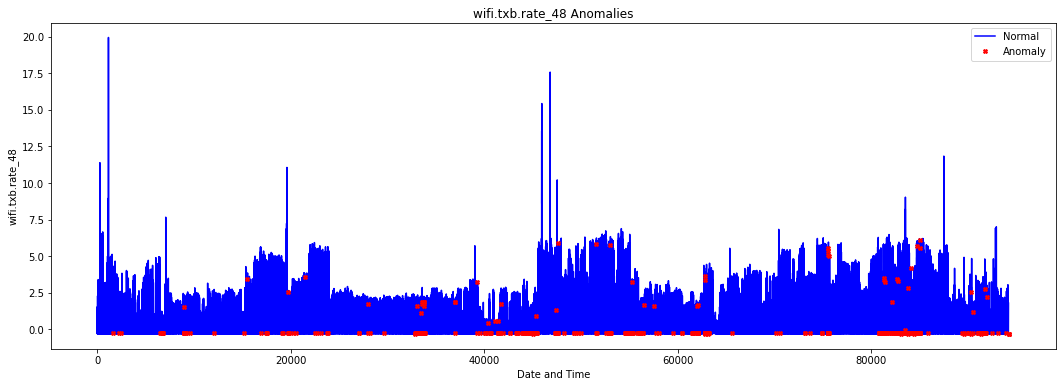

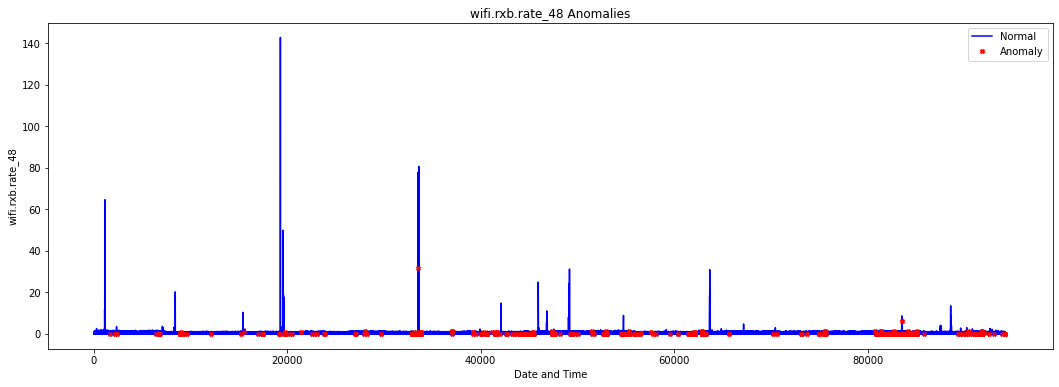

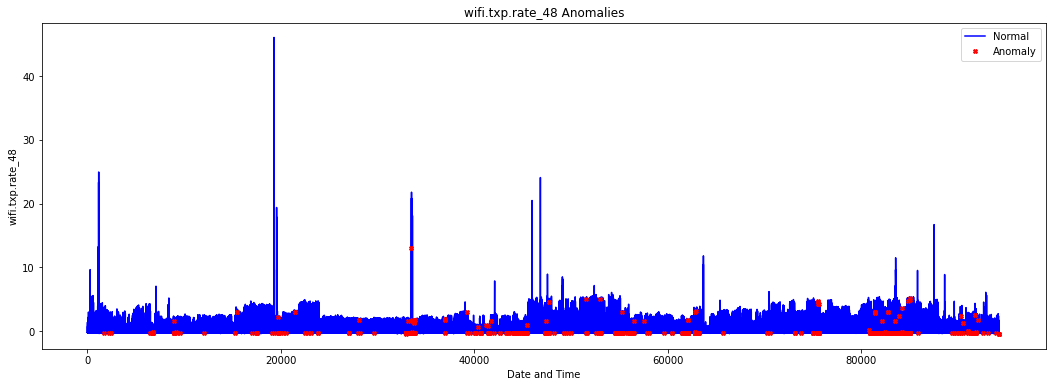

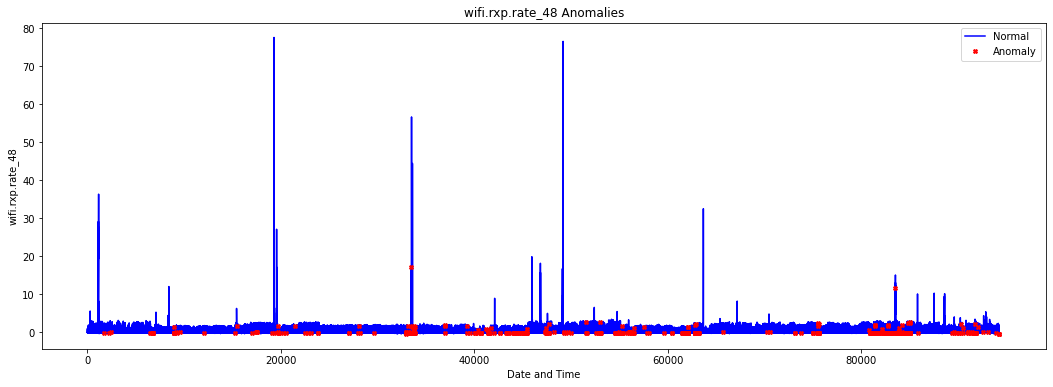

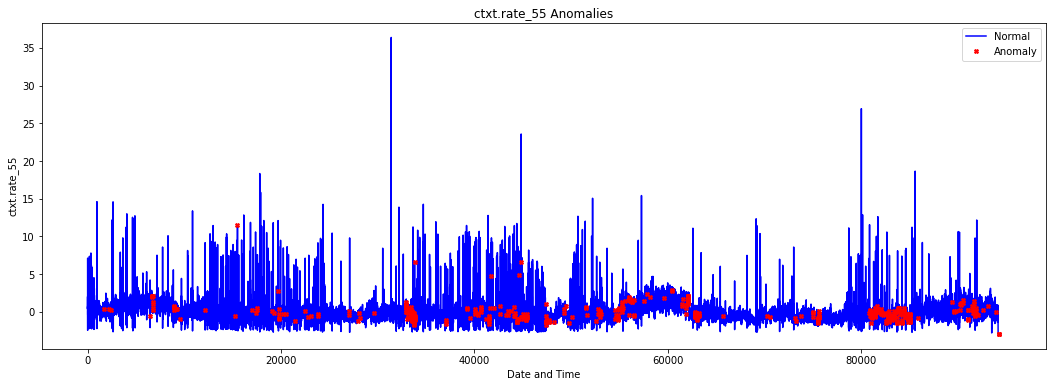

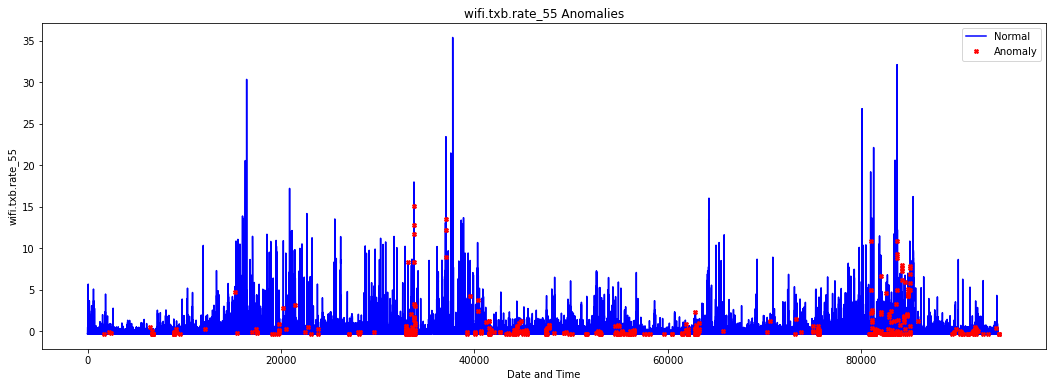

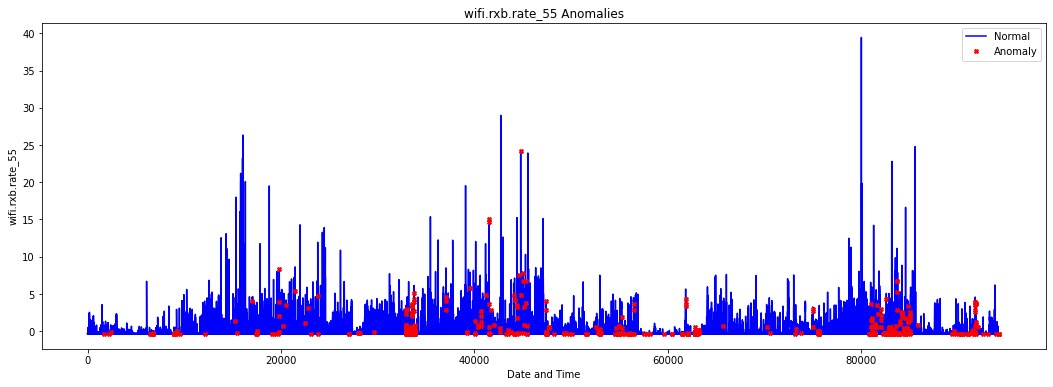

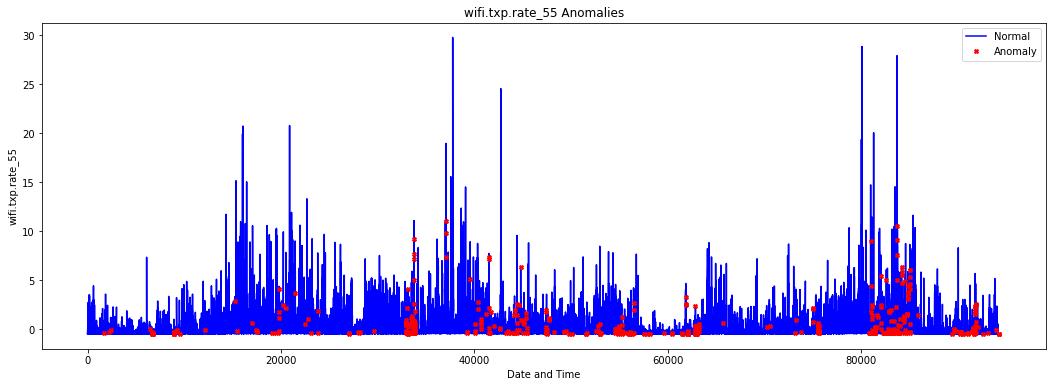

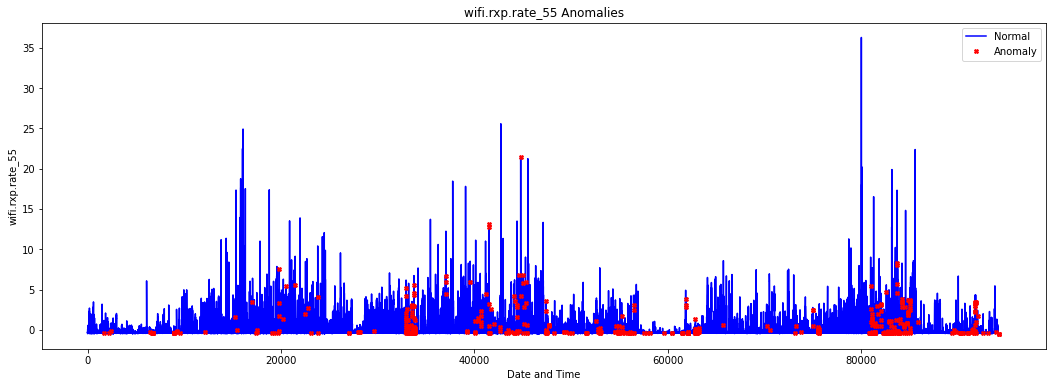

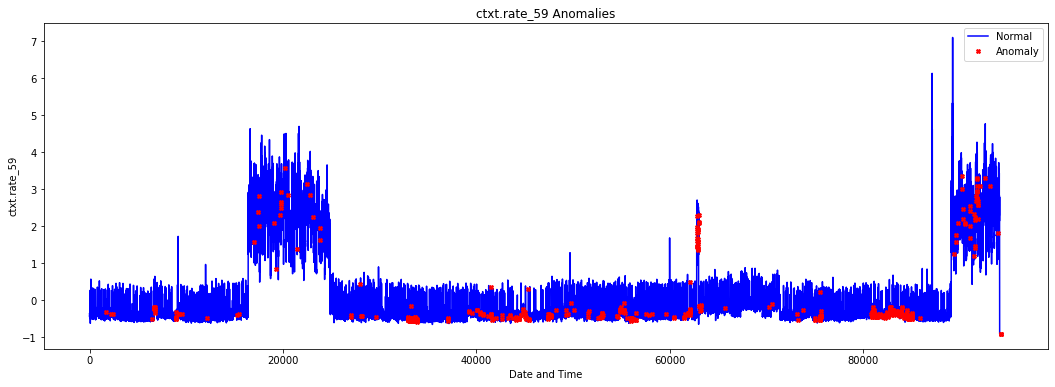

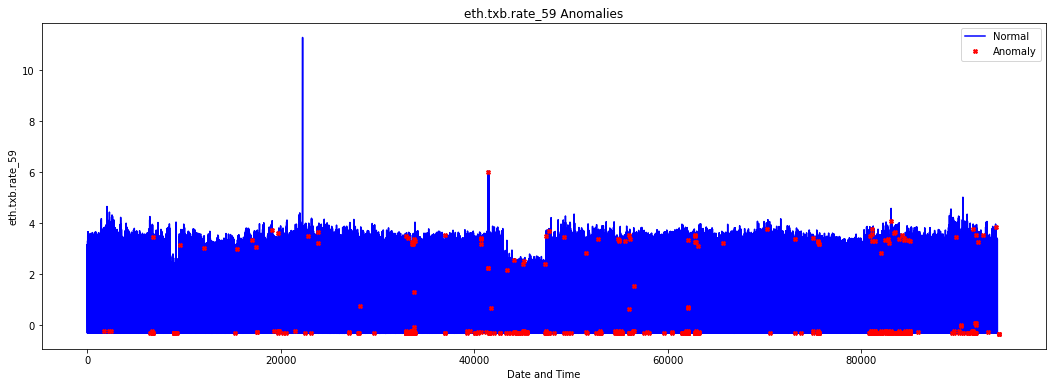

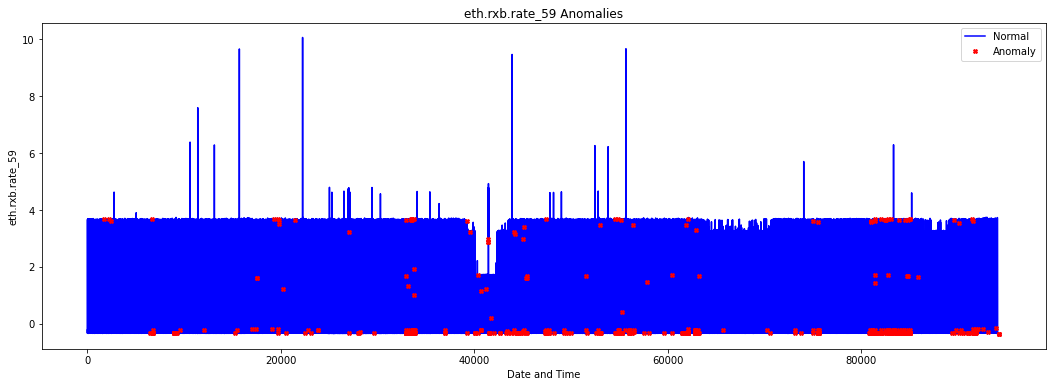

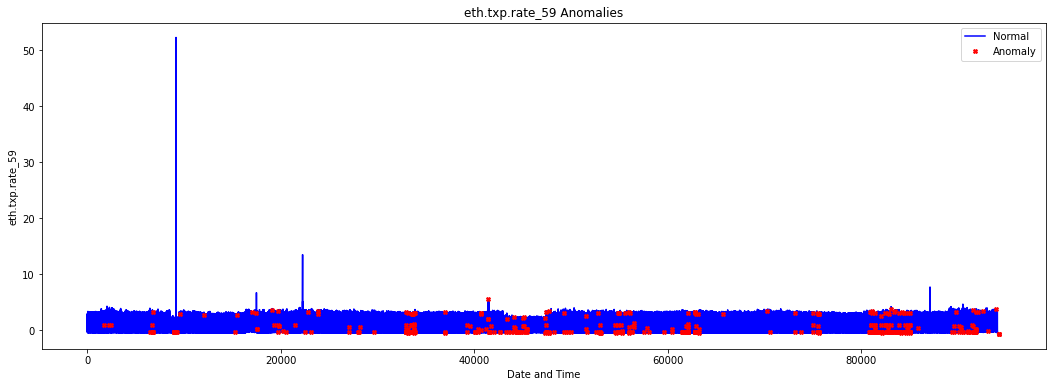

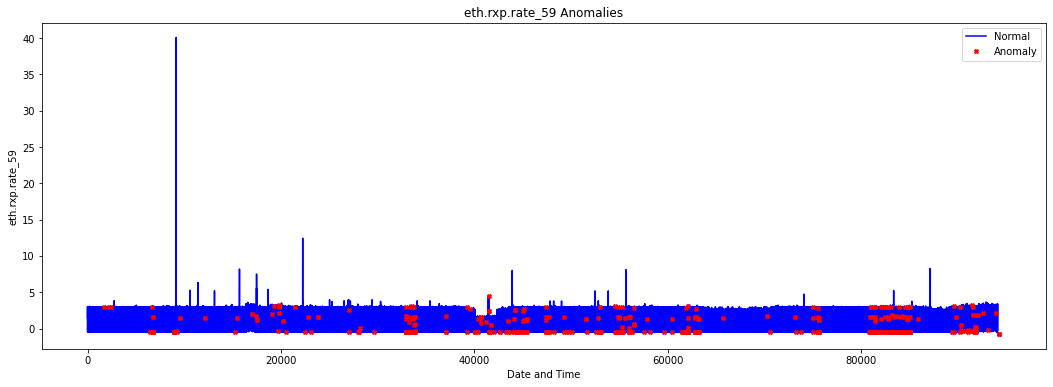

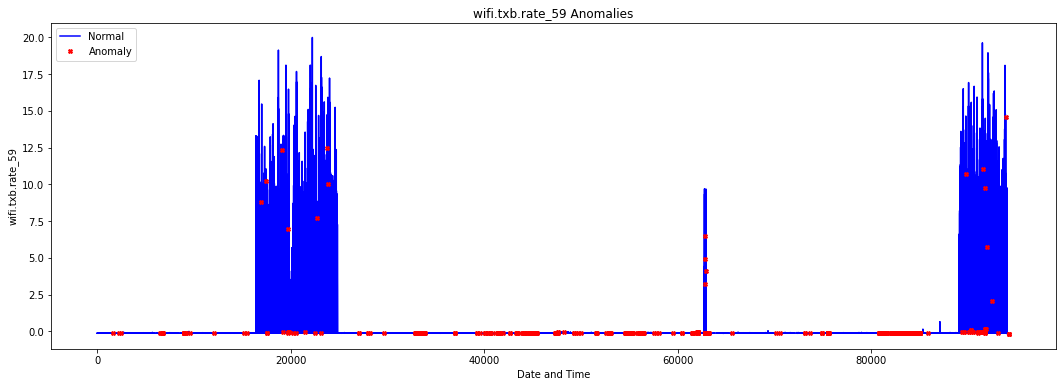

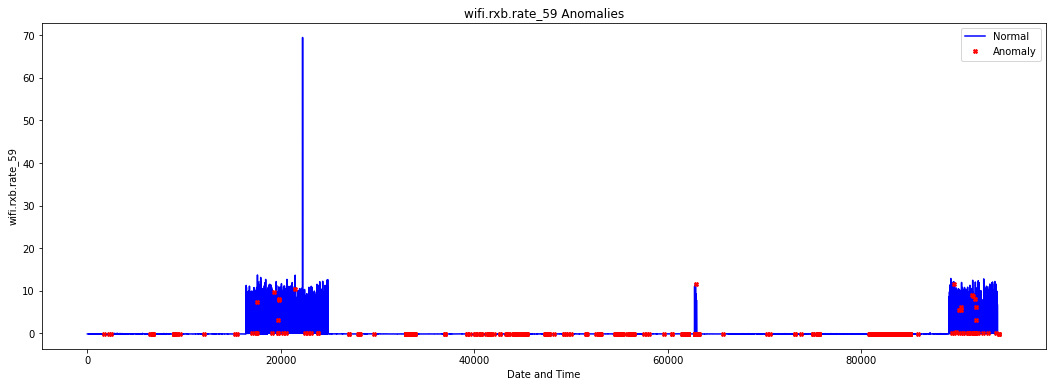

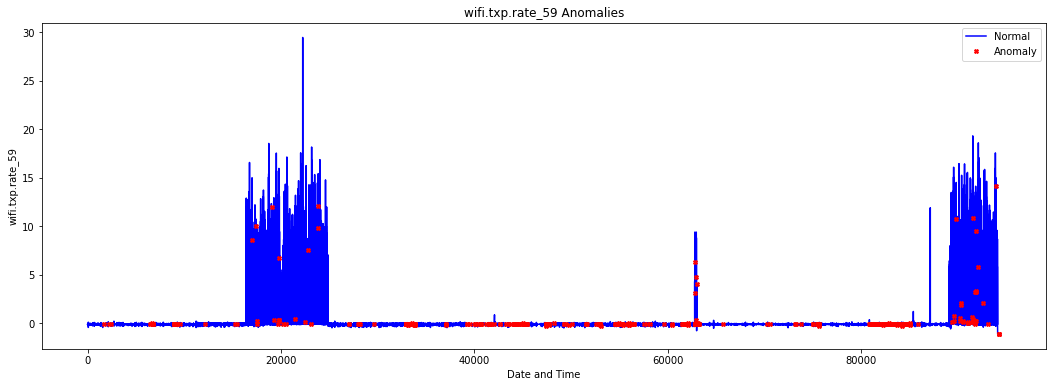

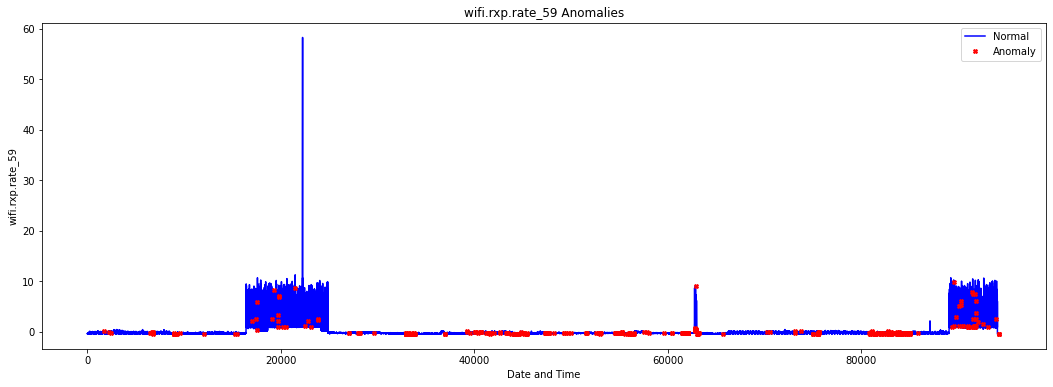

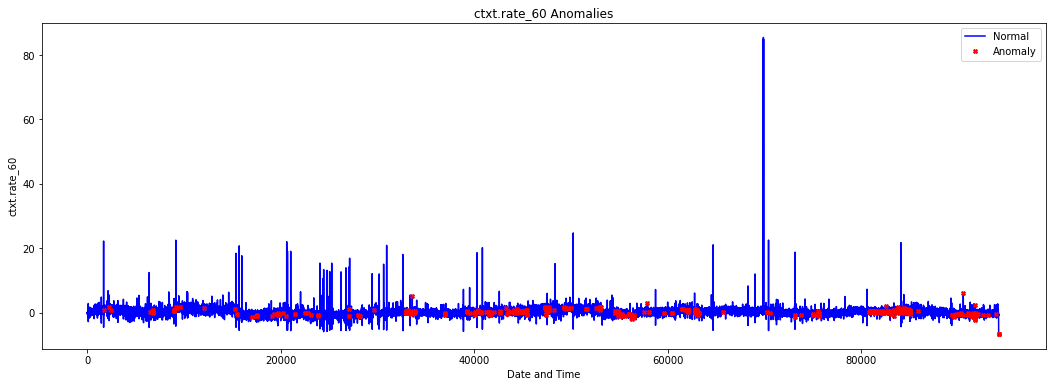

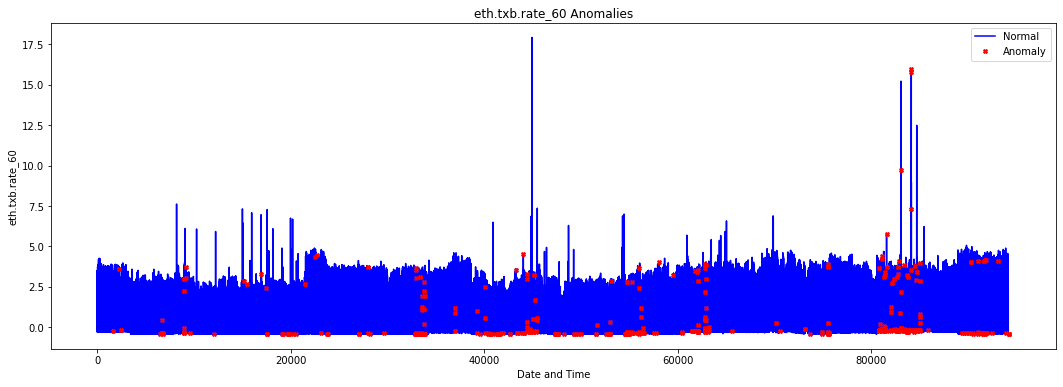

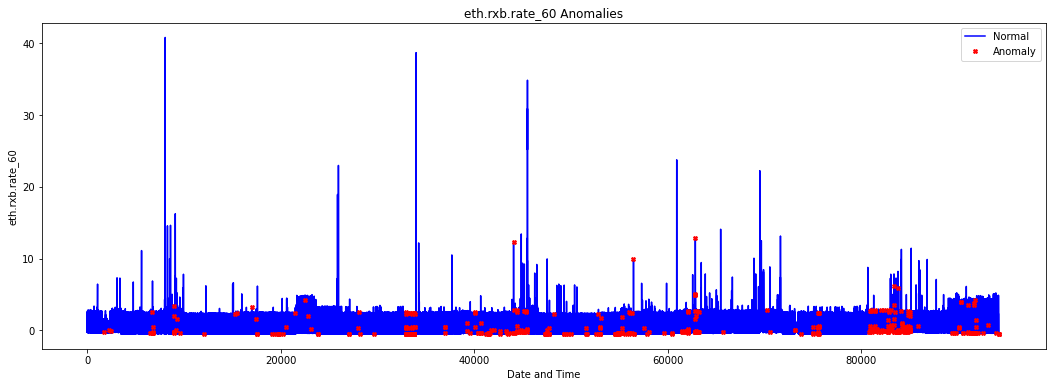

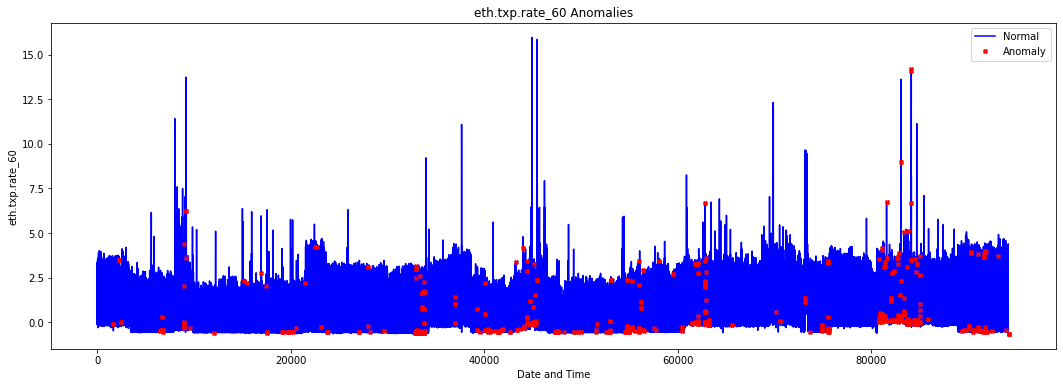

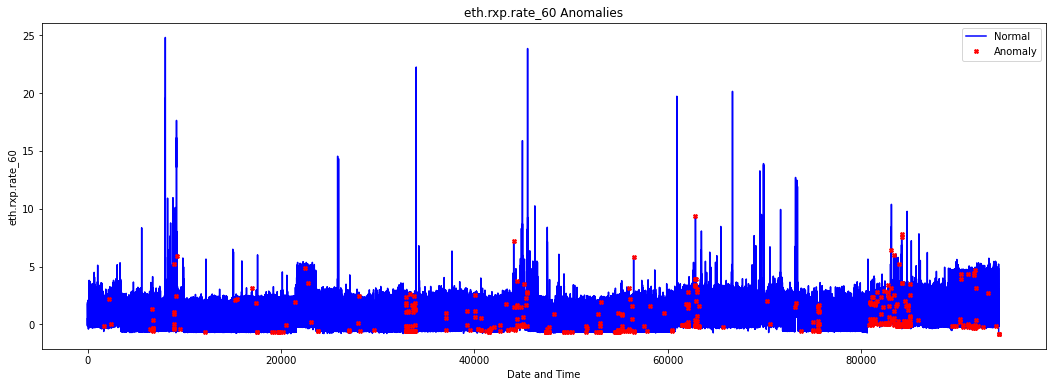

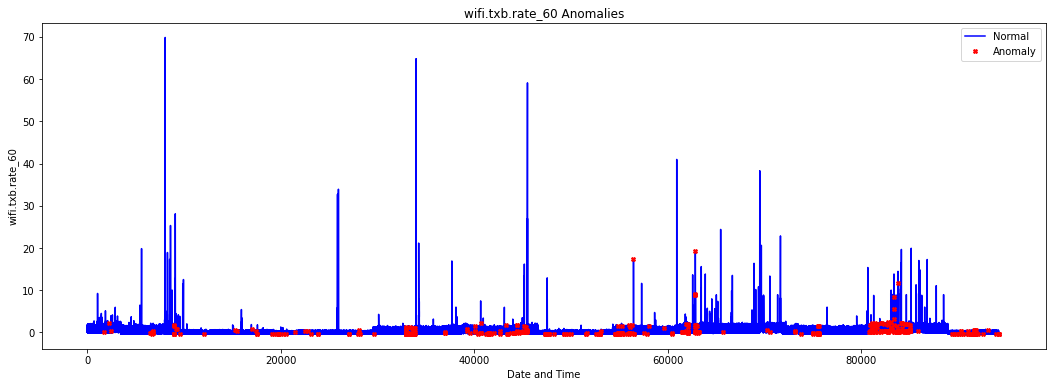

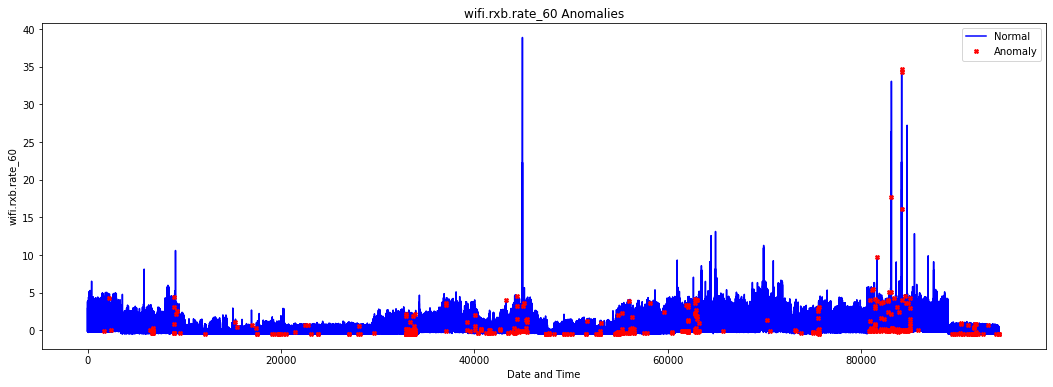

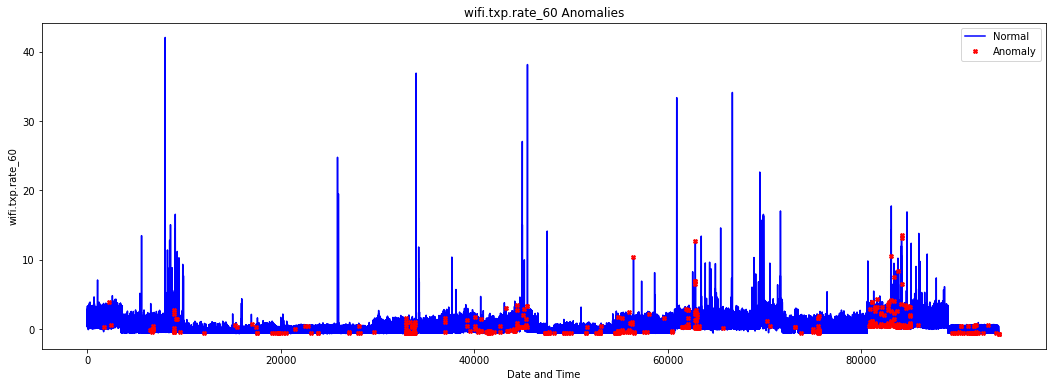

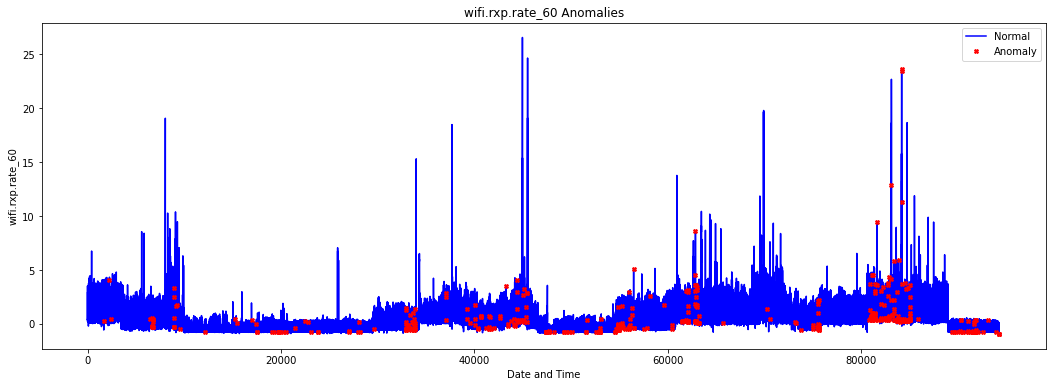

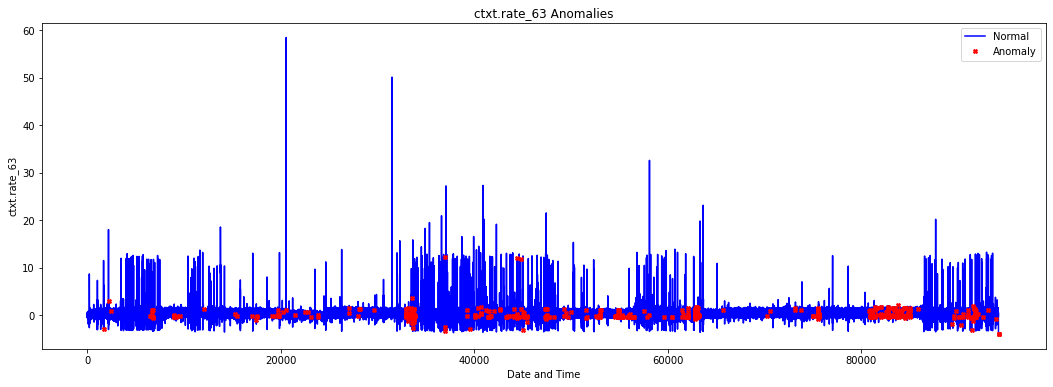

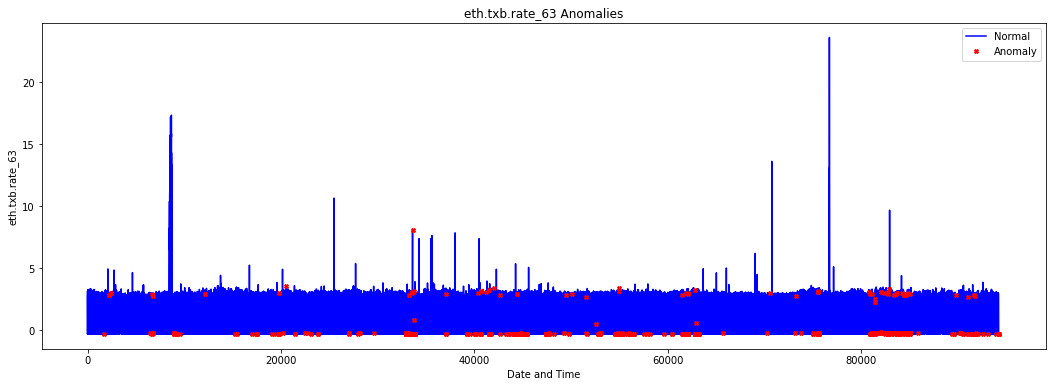

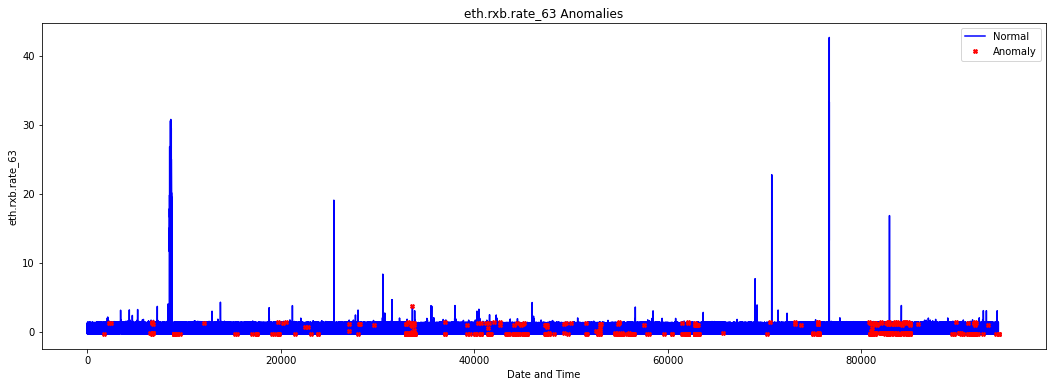

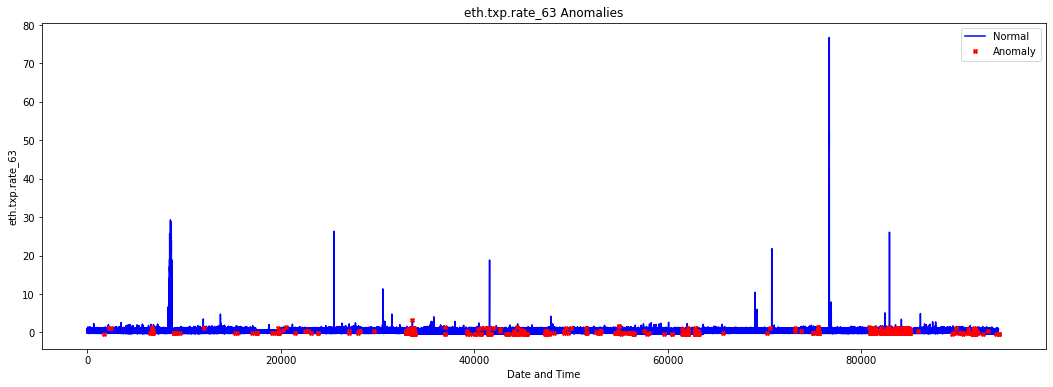

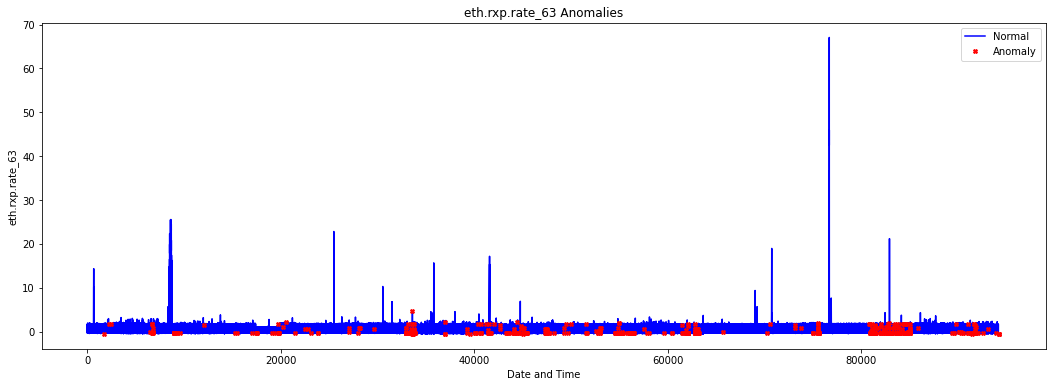

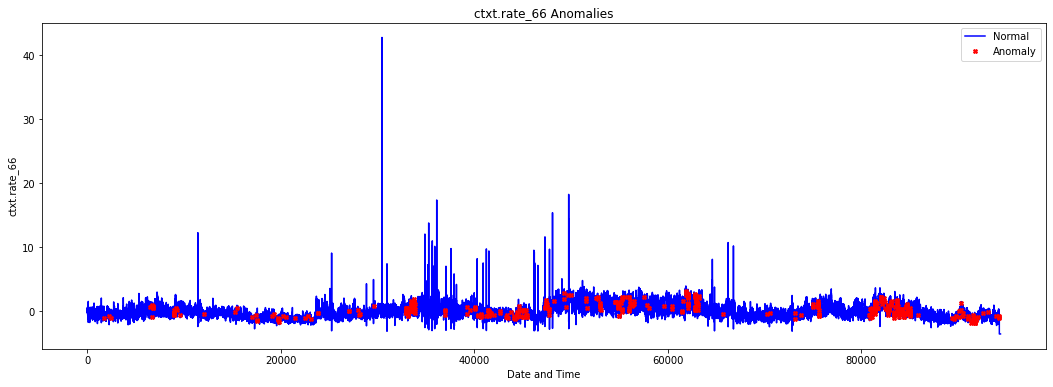

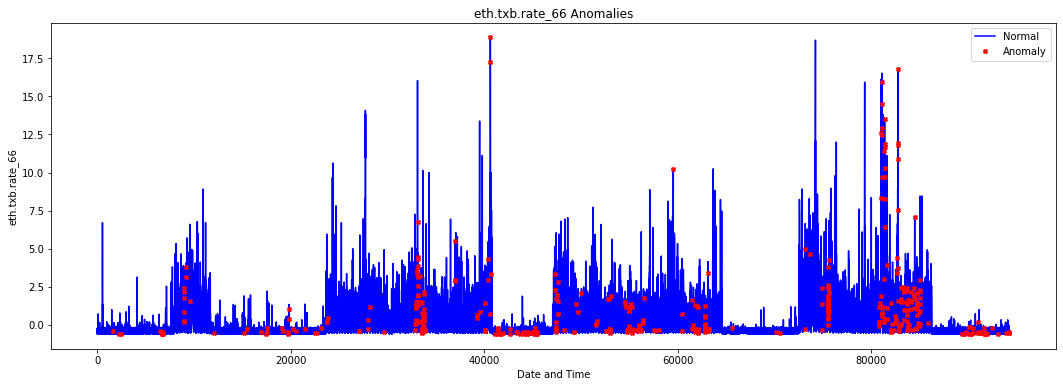

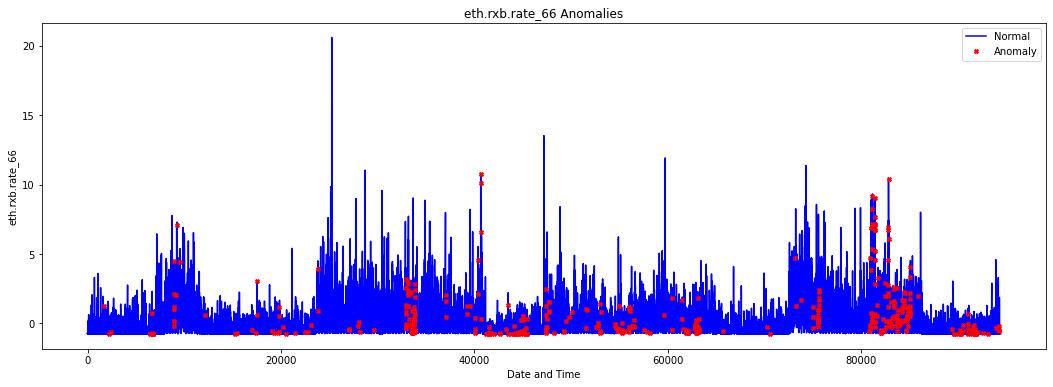

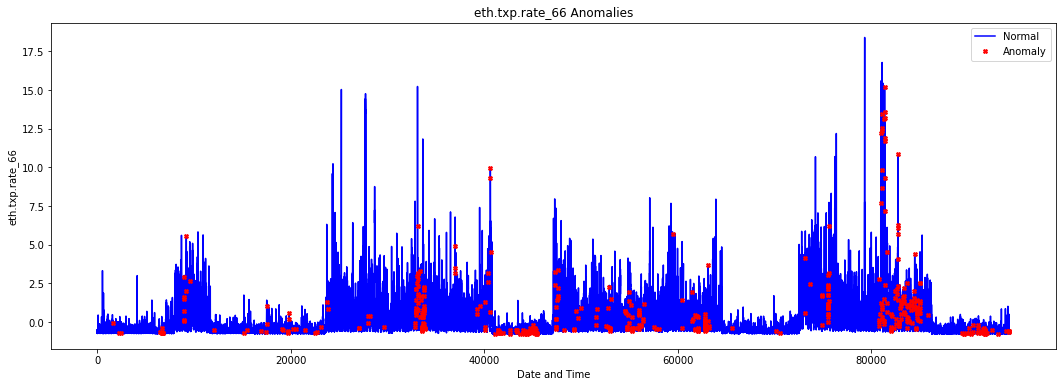

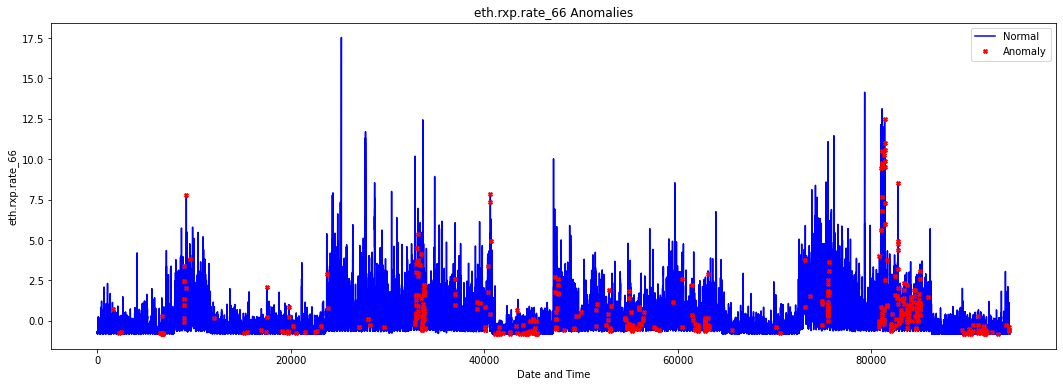

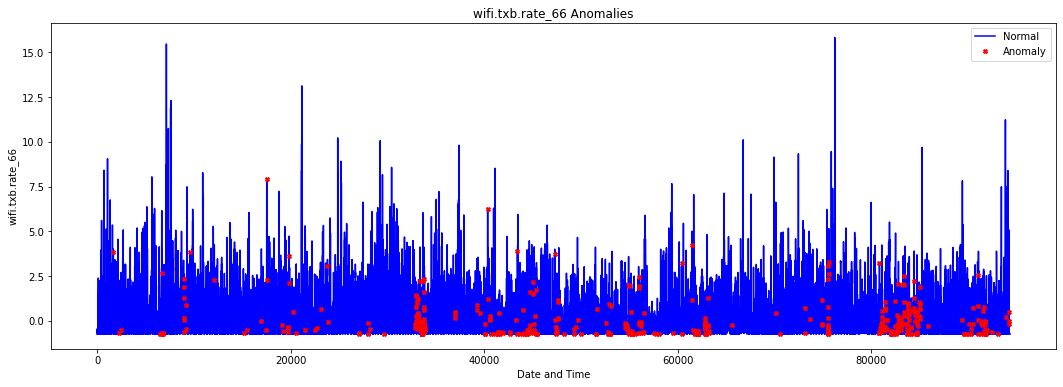

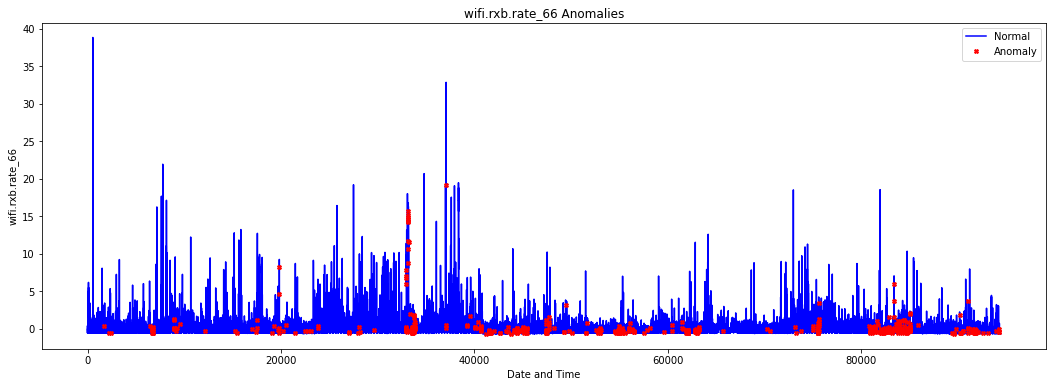

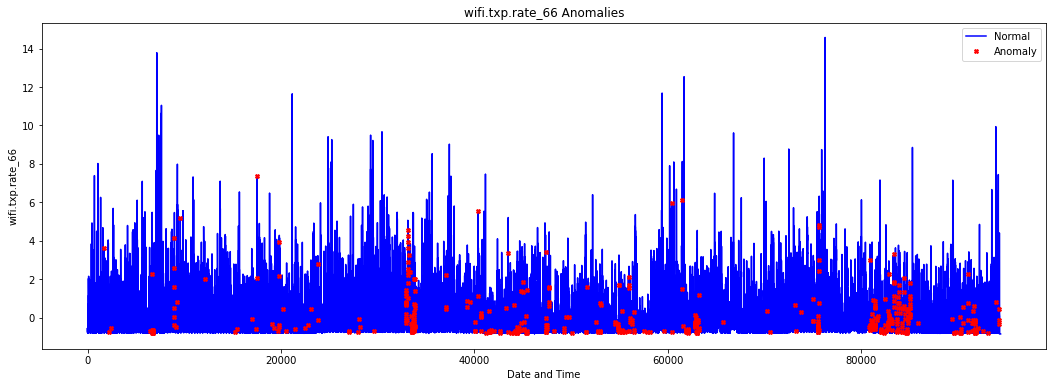

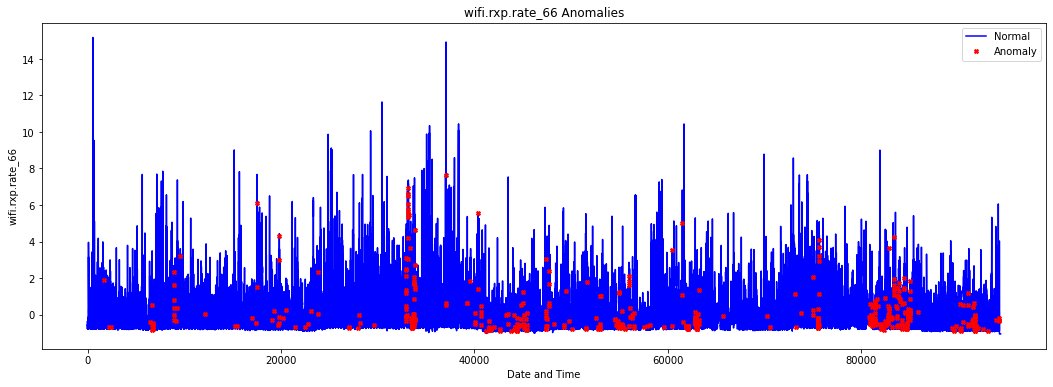

In [14]:
# Add anomalies to all columns from raw dataframe
plot_on_features(dataset_raw, pred, anomay_label=-1)


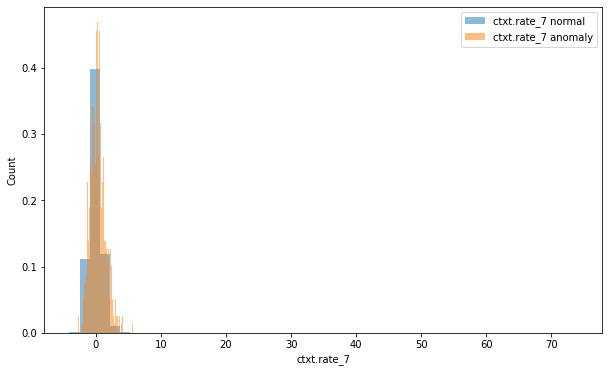

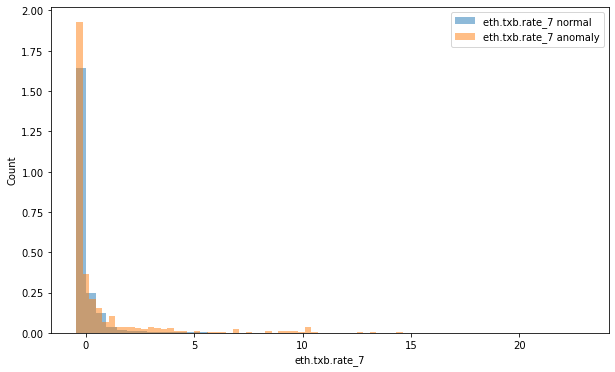

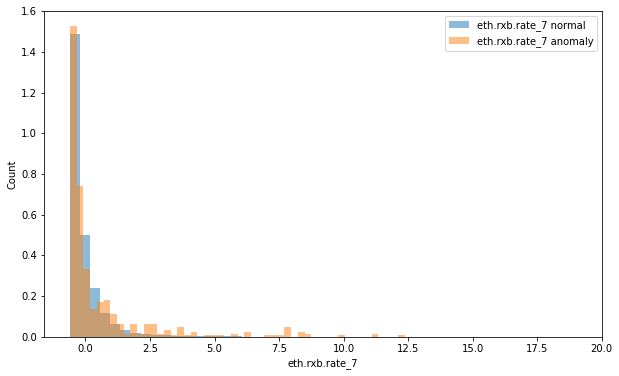

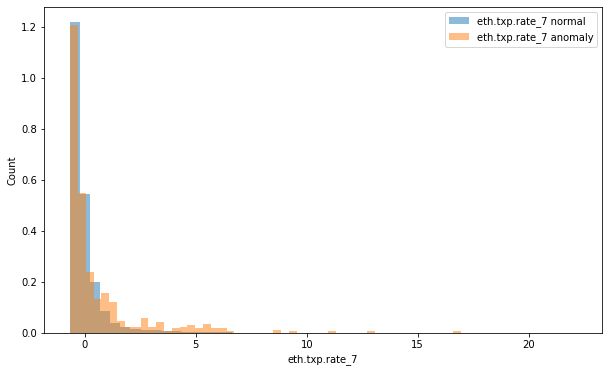

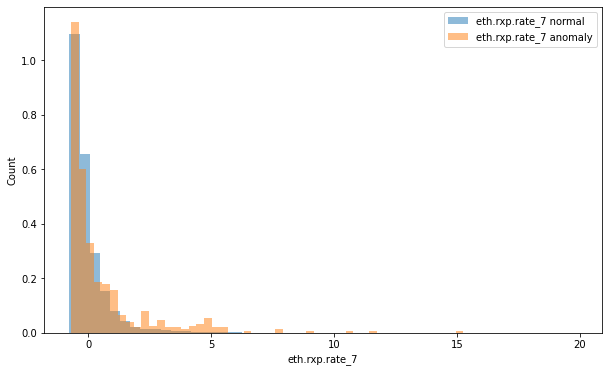

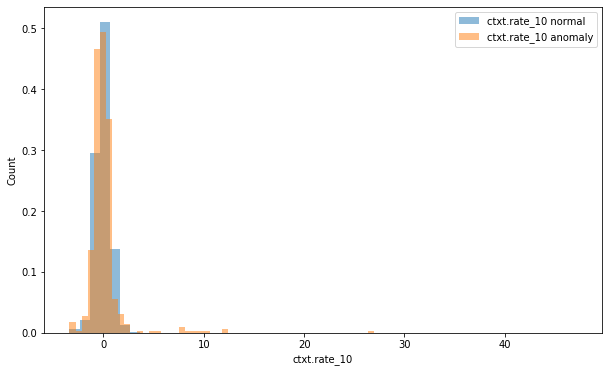

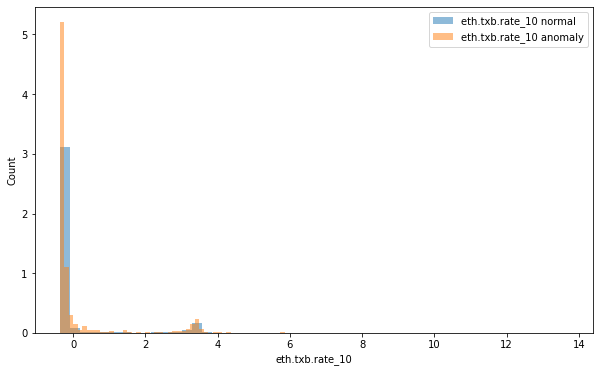

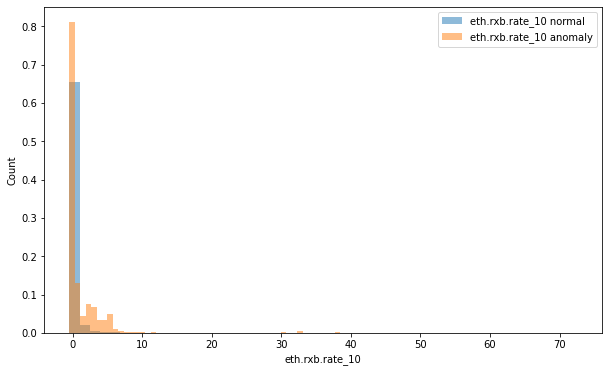

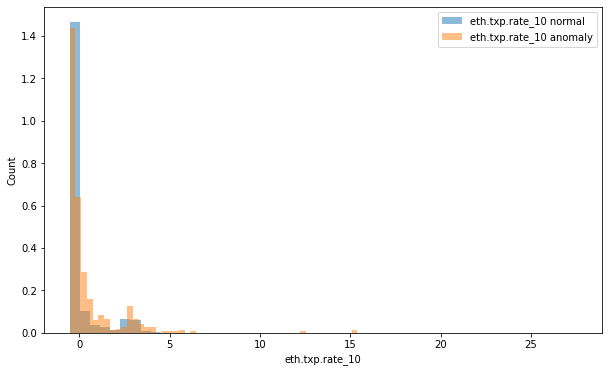

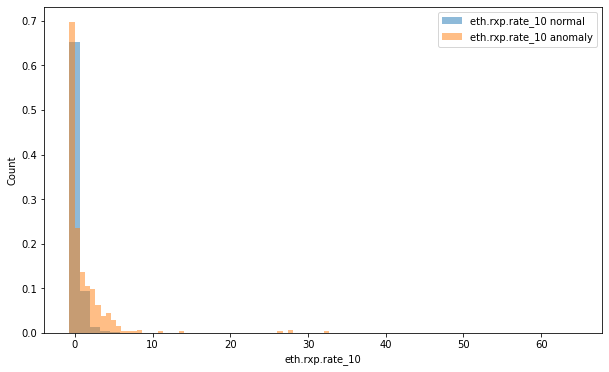

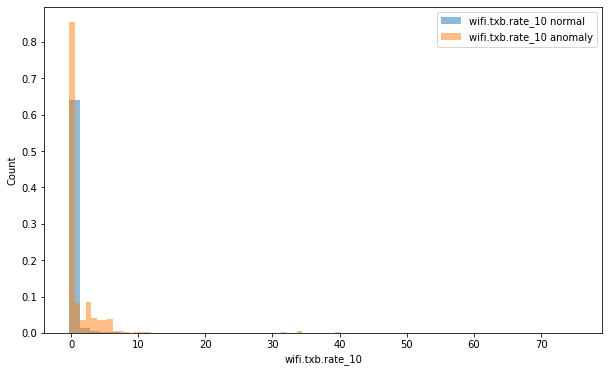

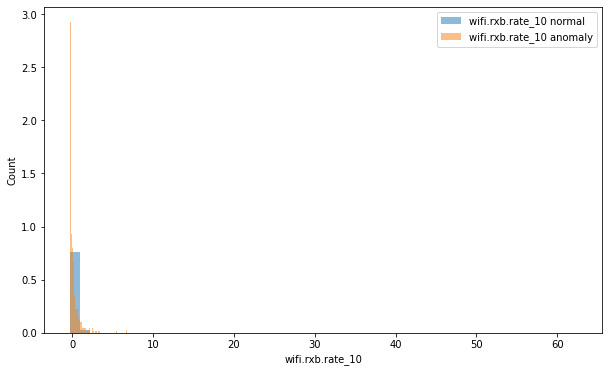

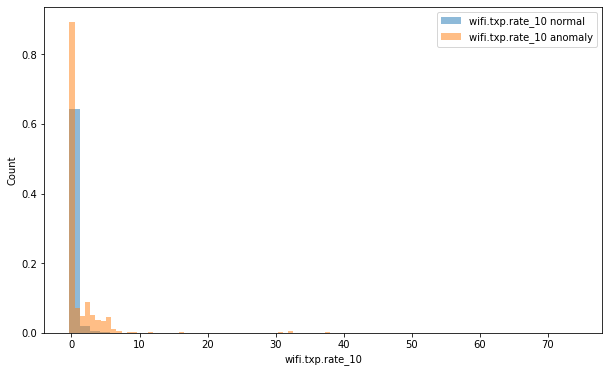

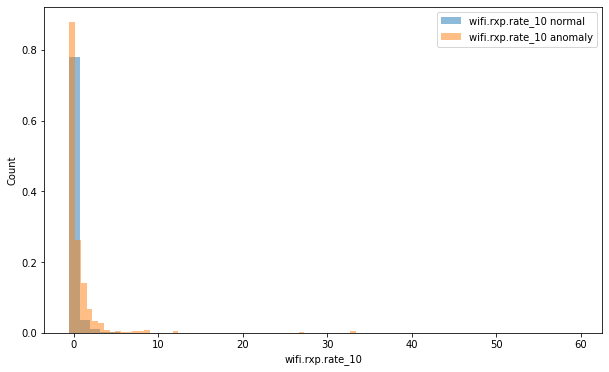

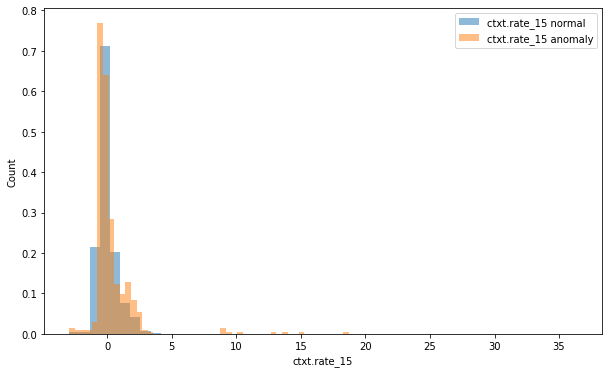

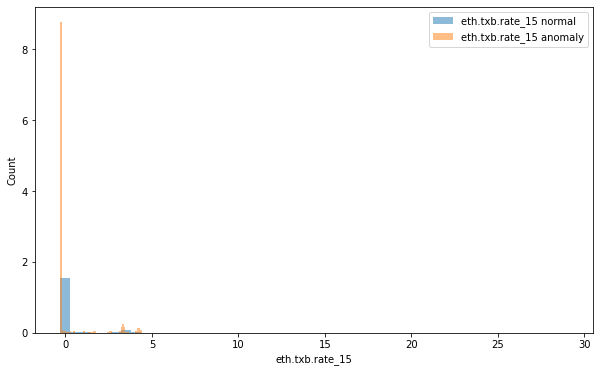

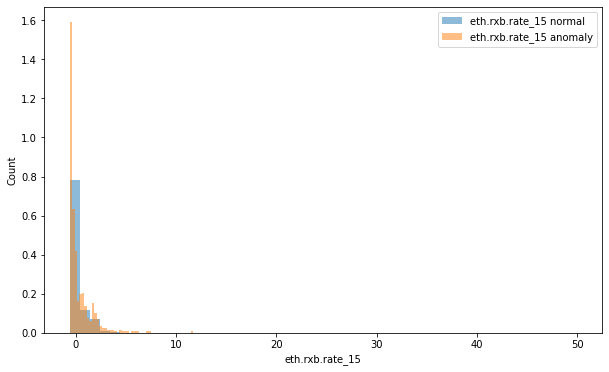

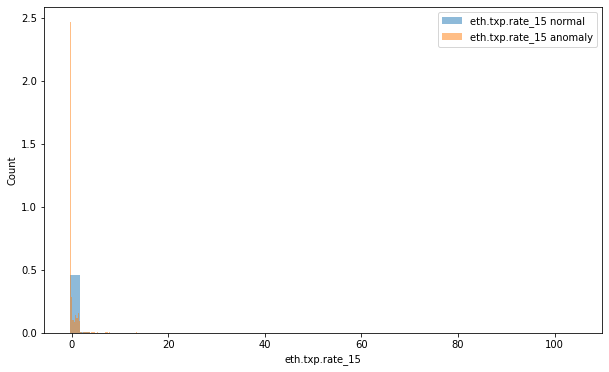

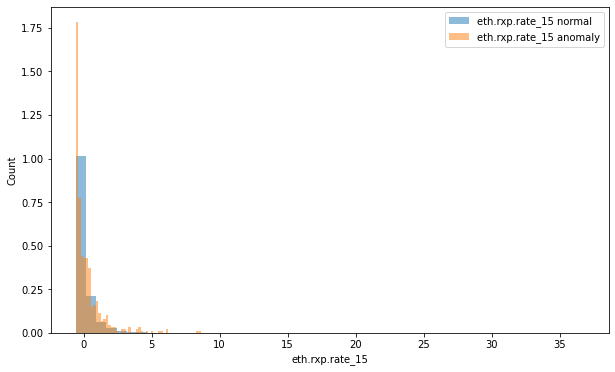

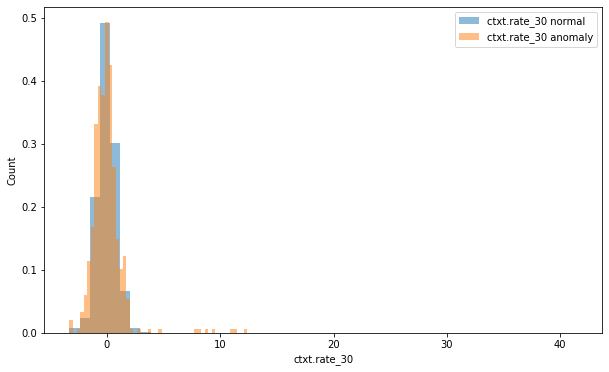

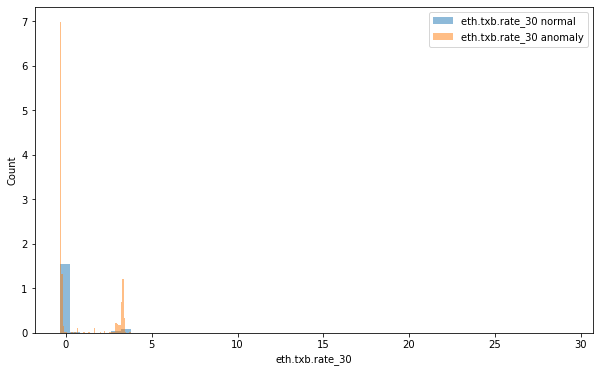

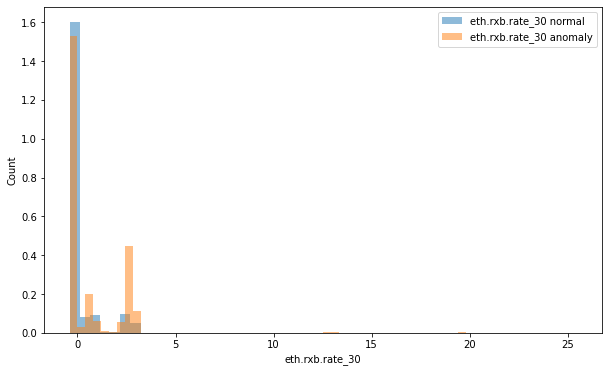

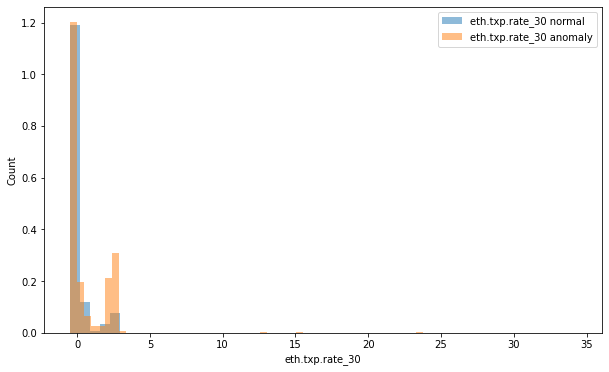

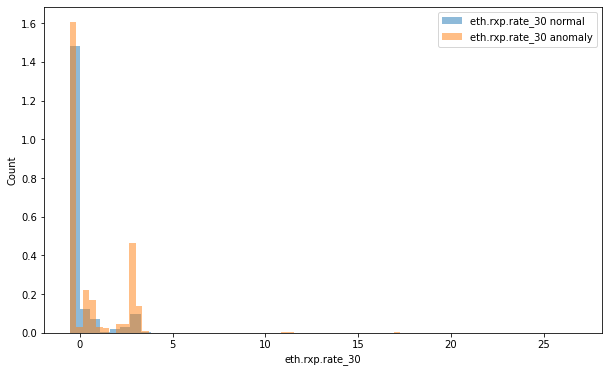

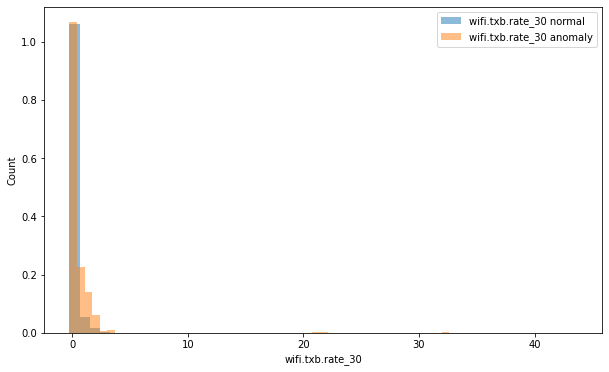

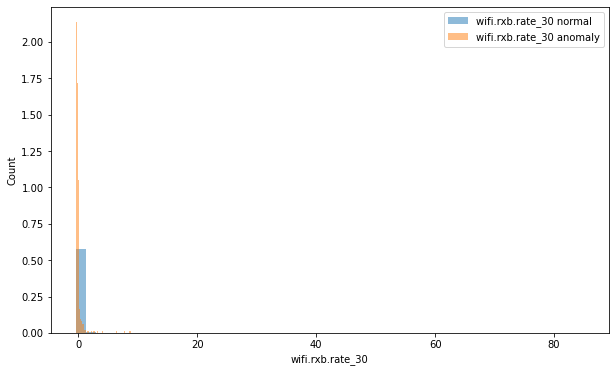

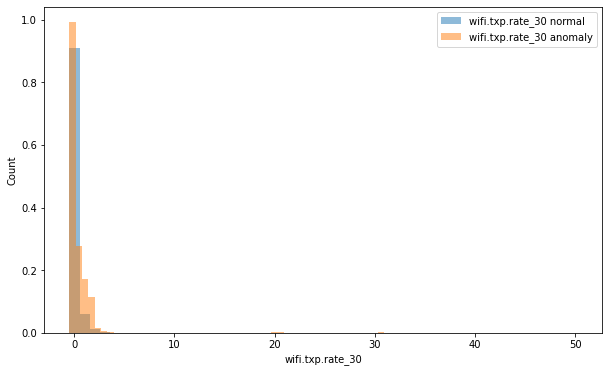

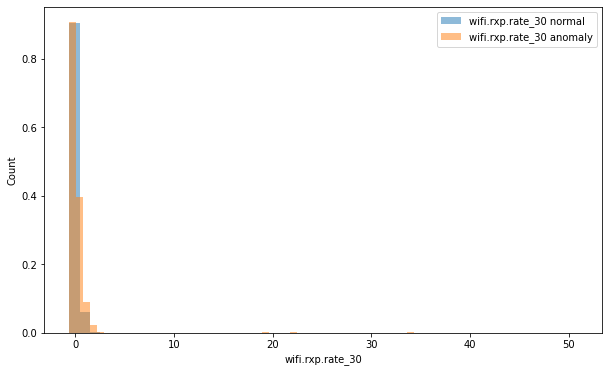

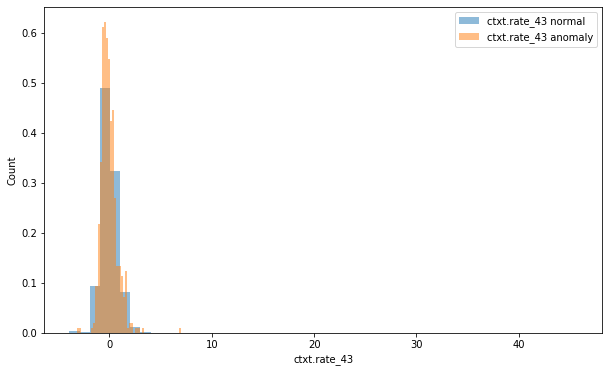

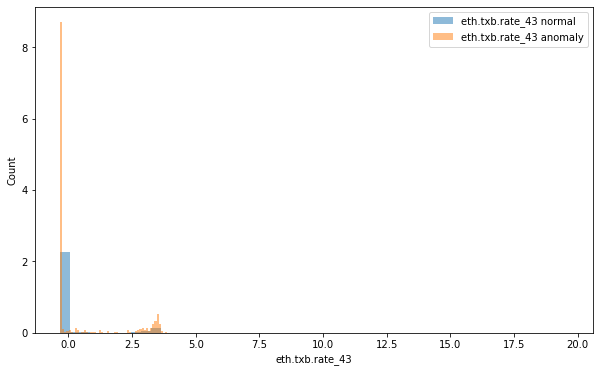

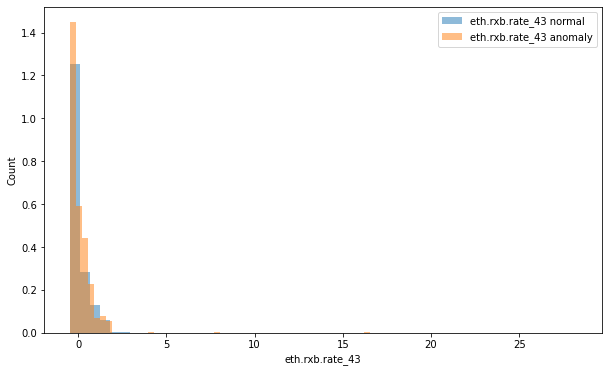

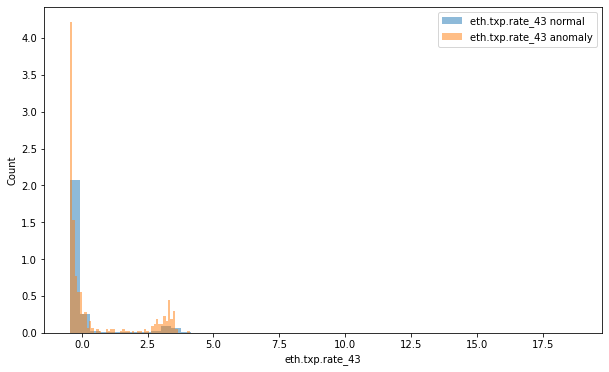

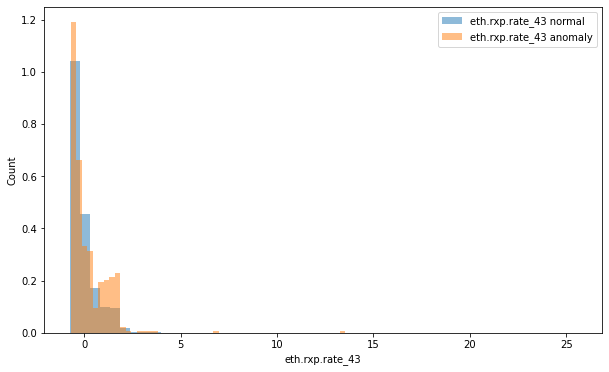

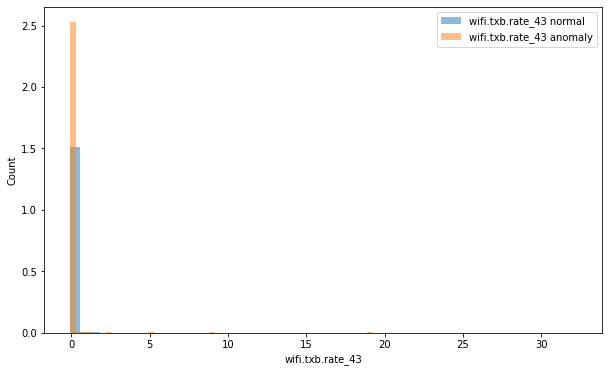

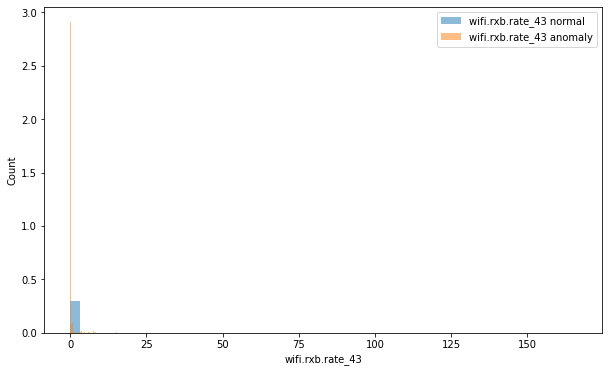

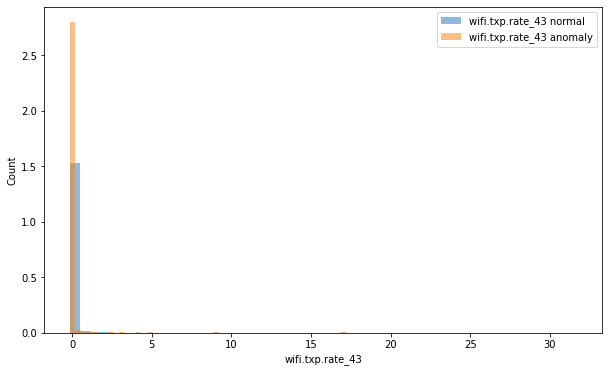

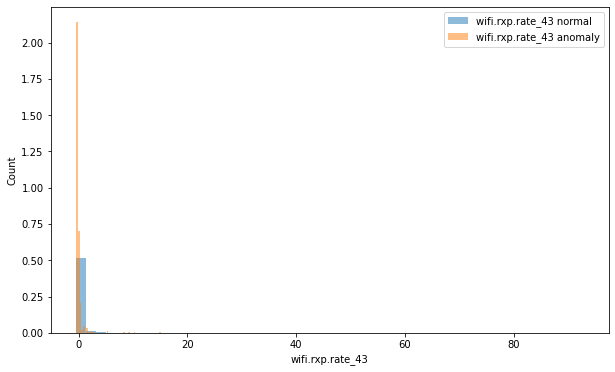

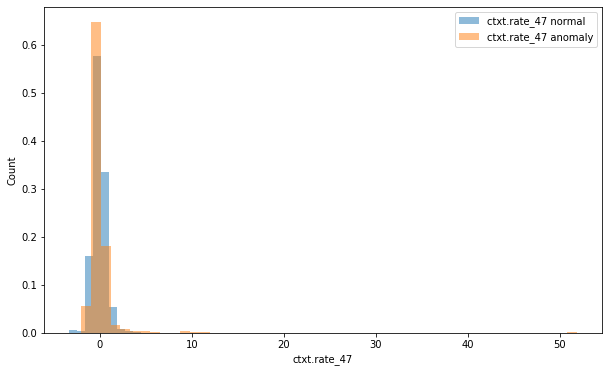

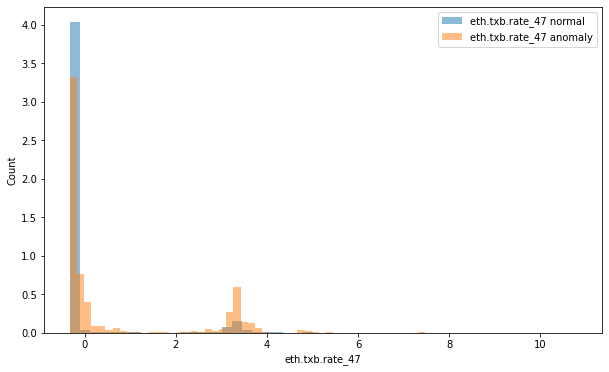

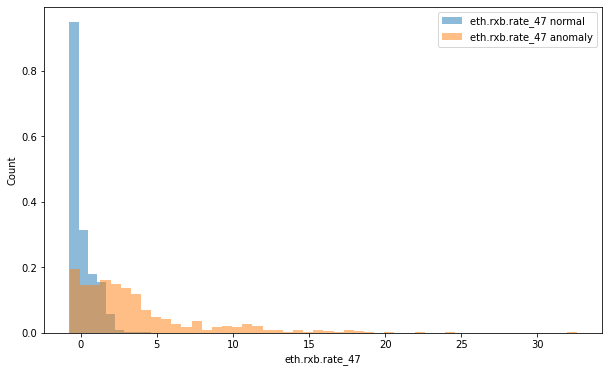

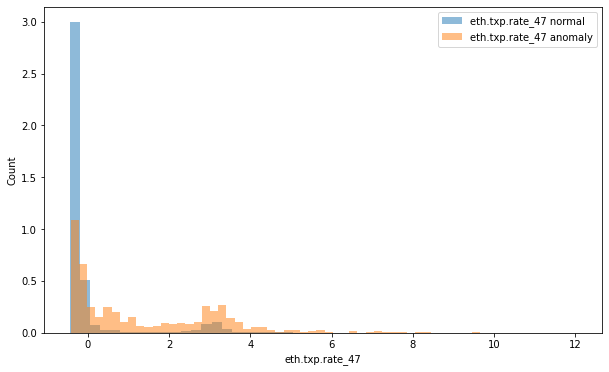

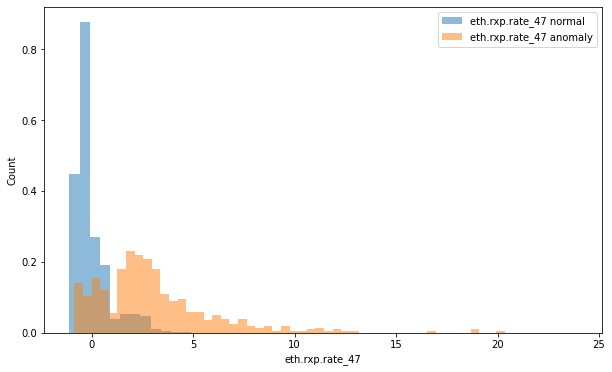

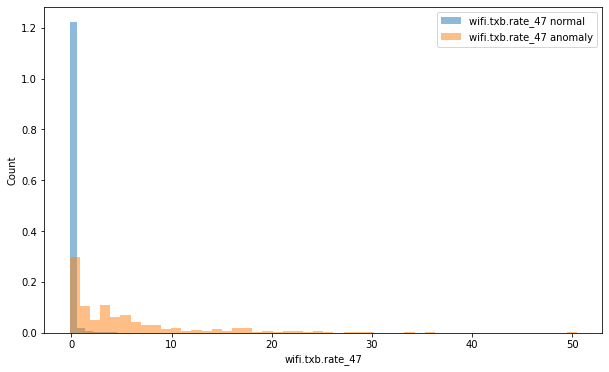

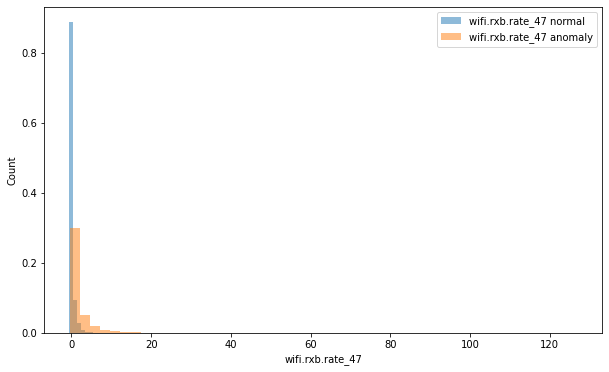

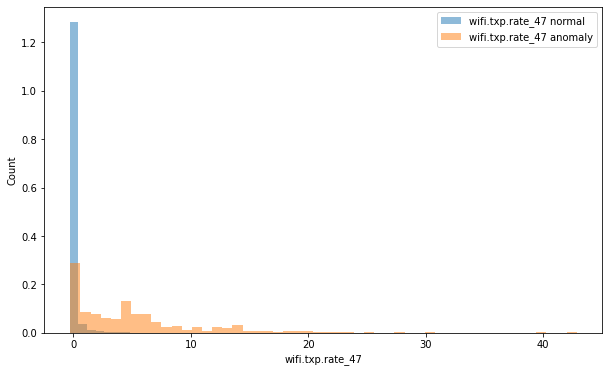

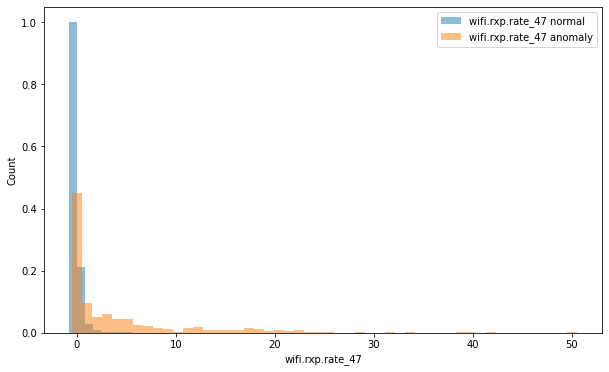

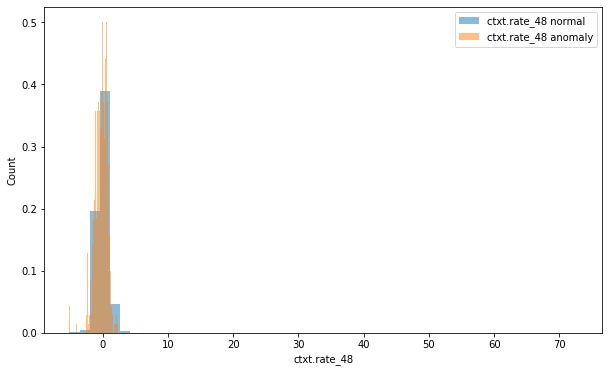

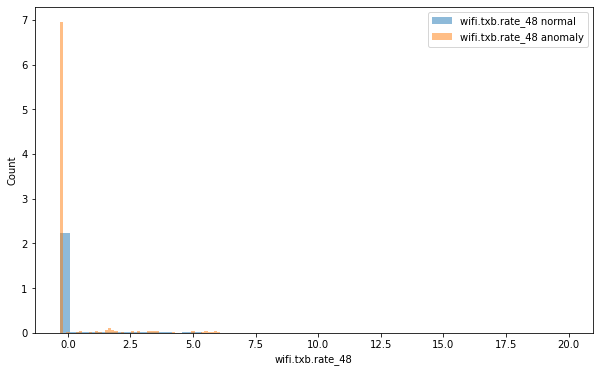

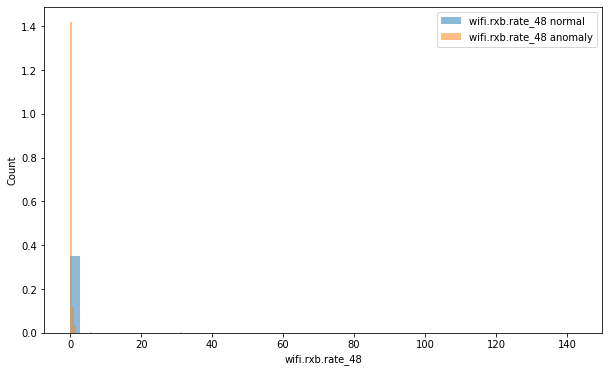

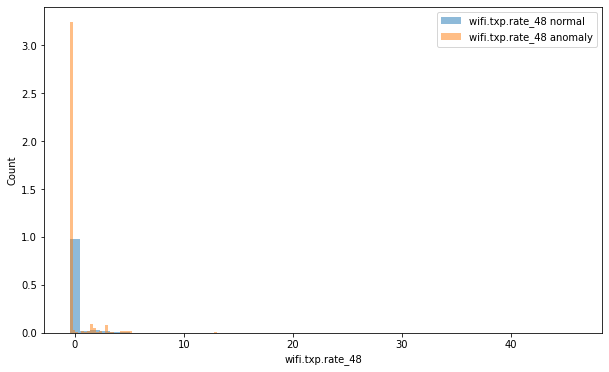

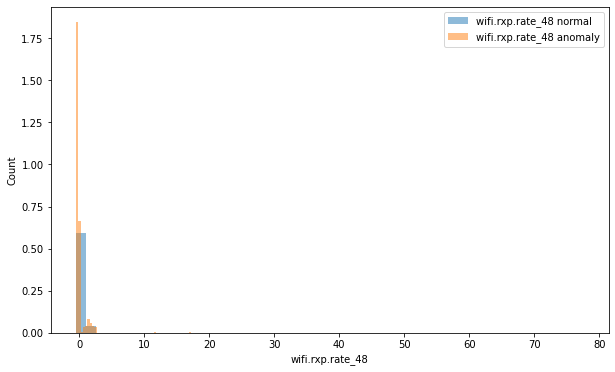

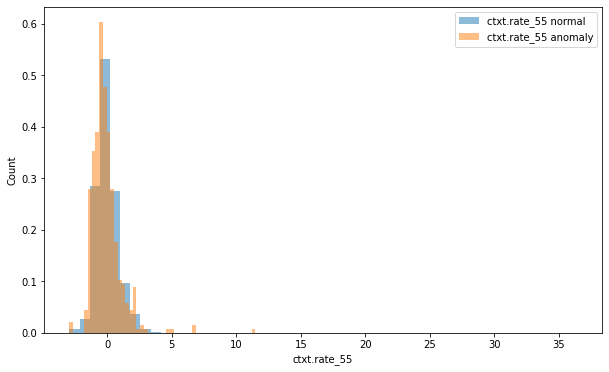

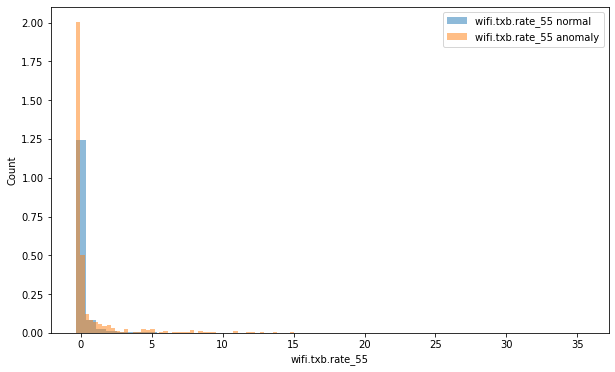

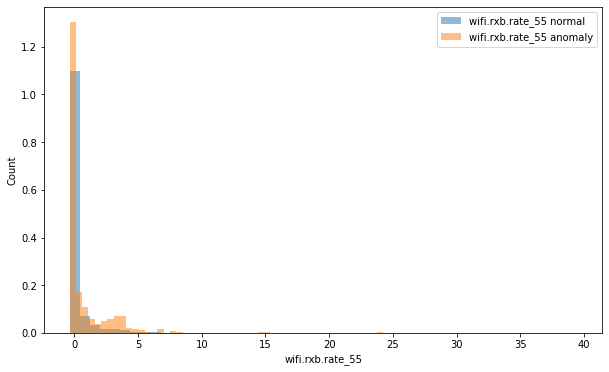

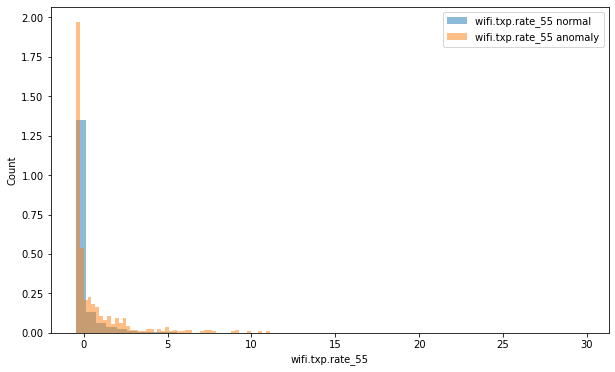

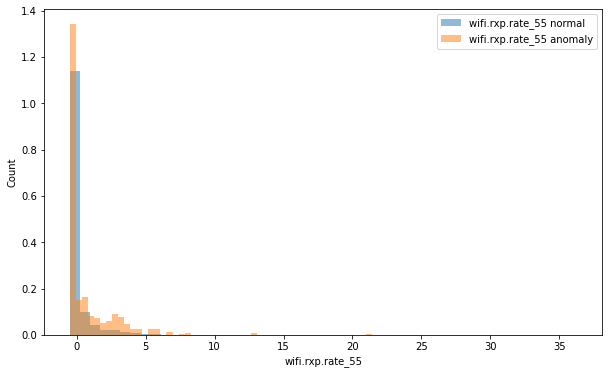

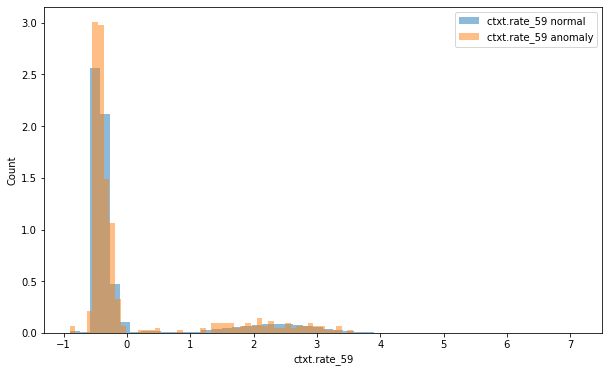

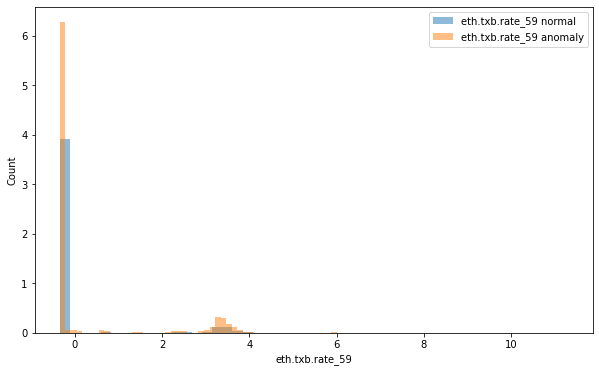

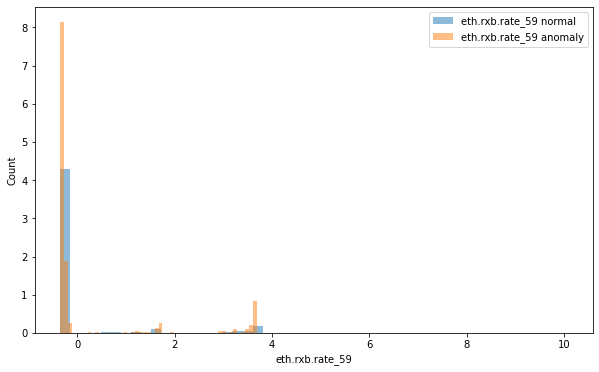

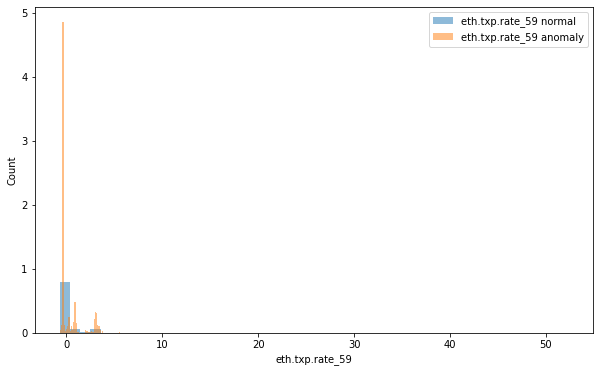

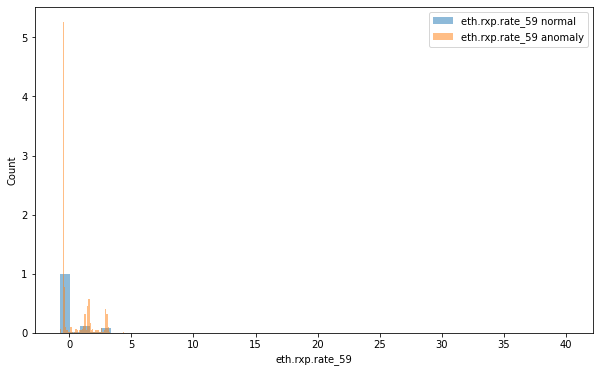

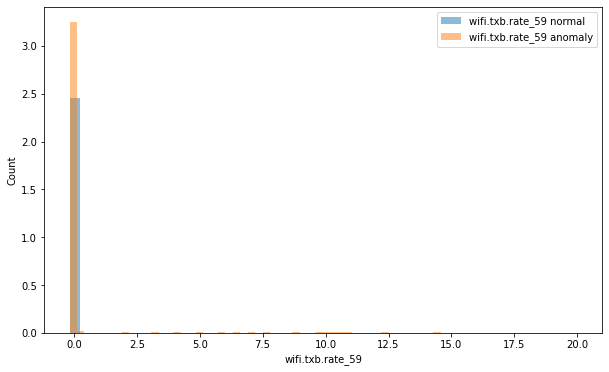

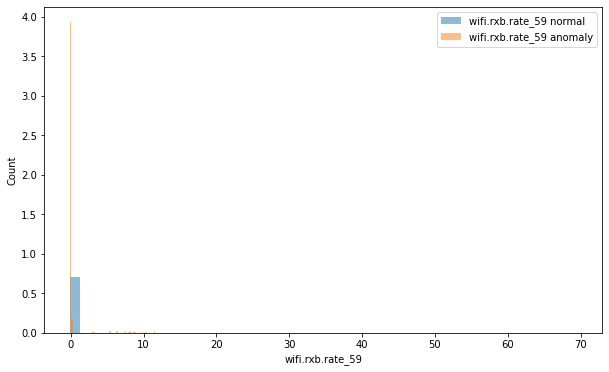

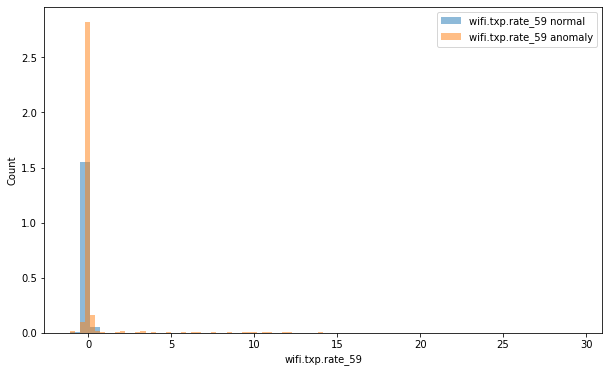

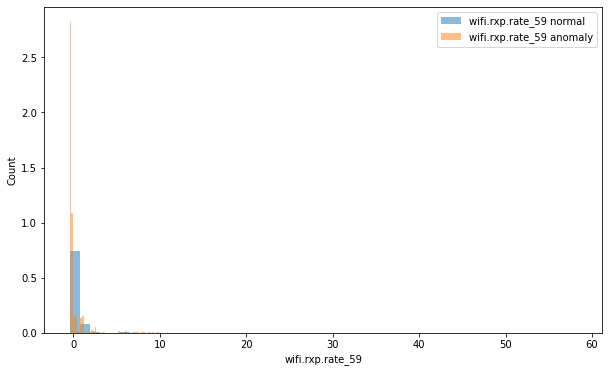

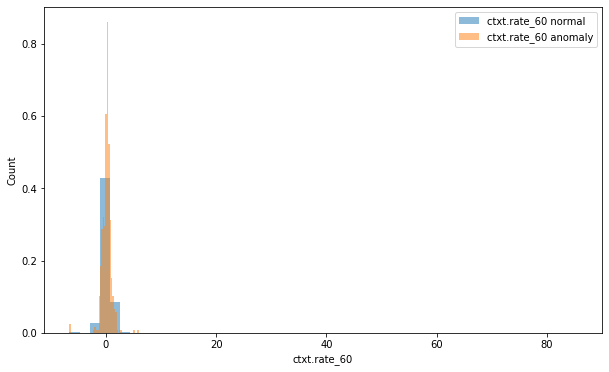

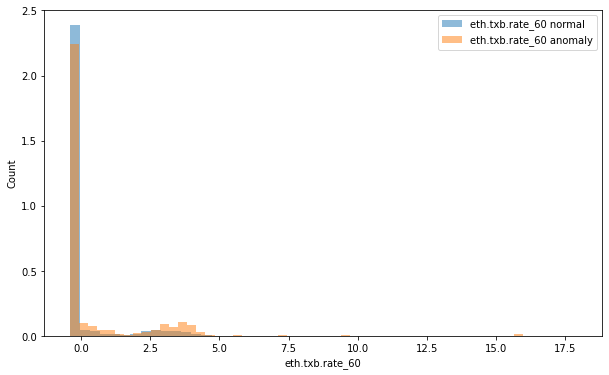

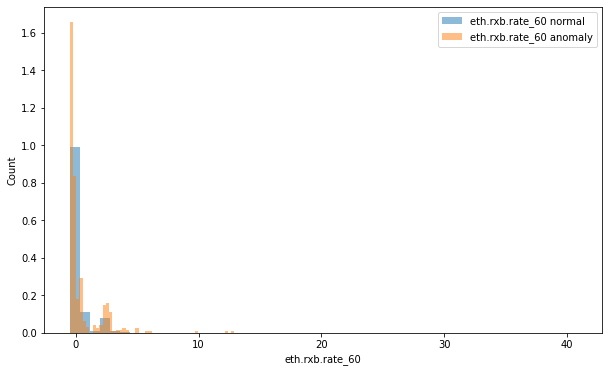

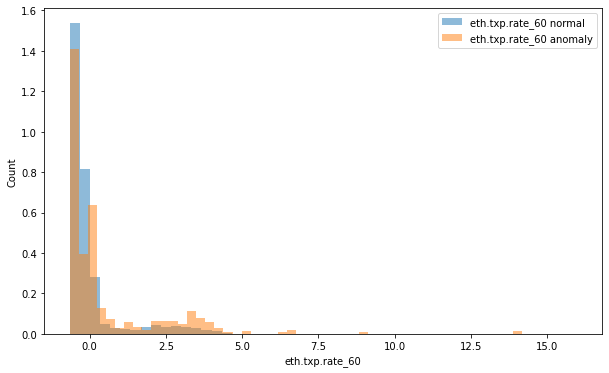

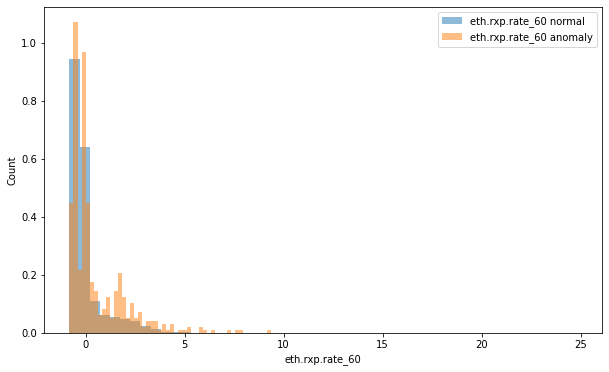

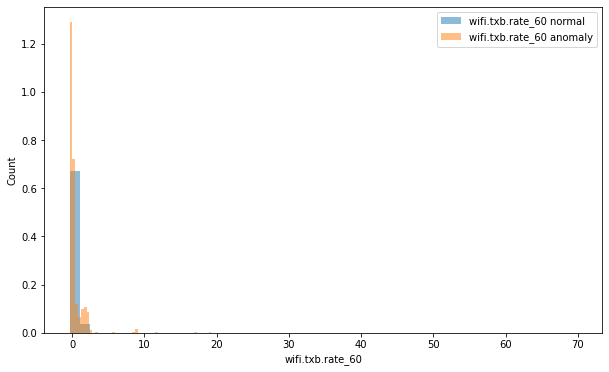

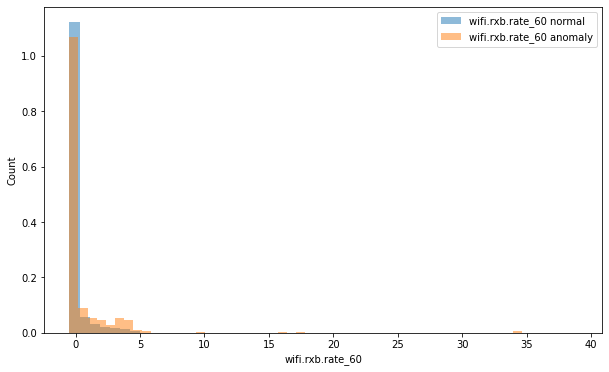

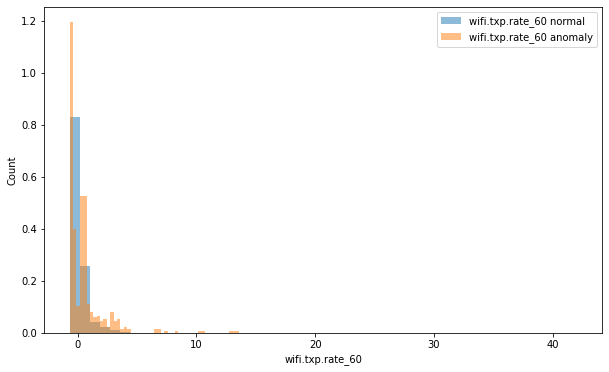

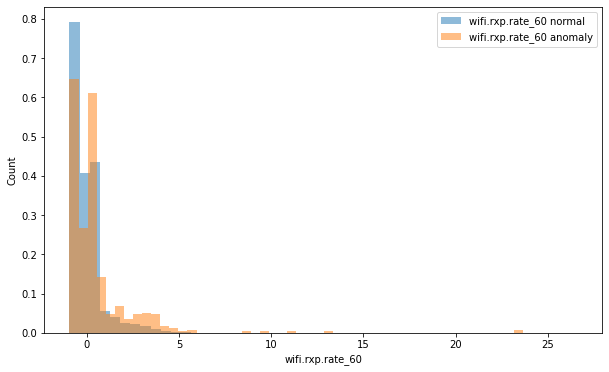

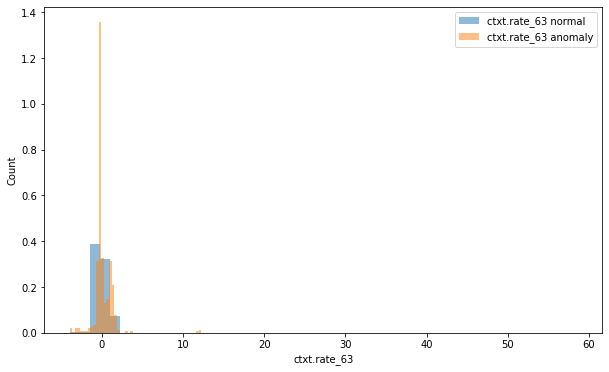

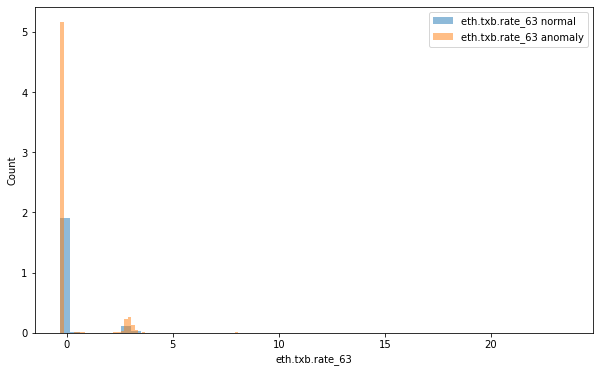

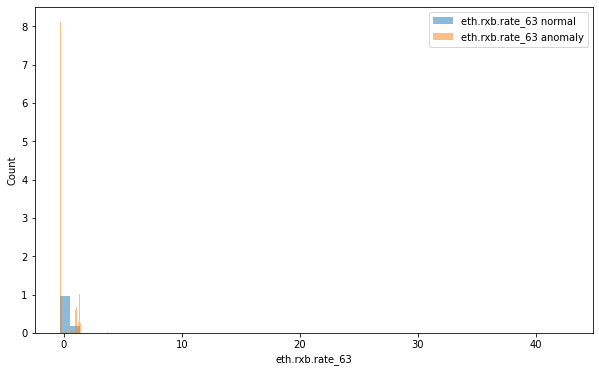

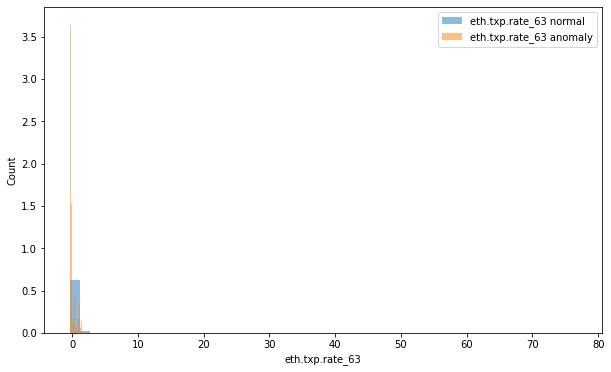

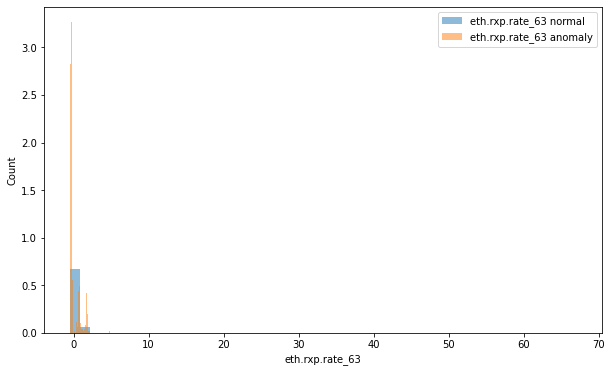

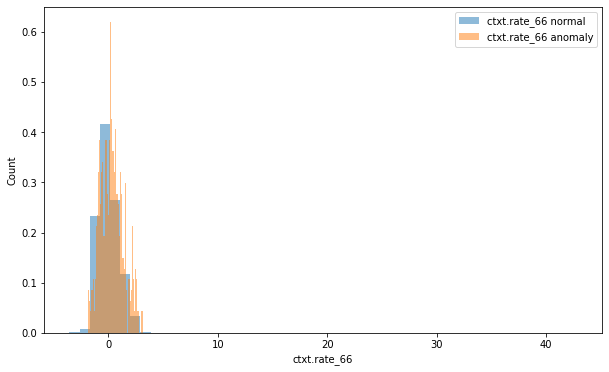

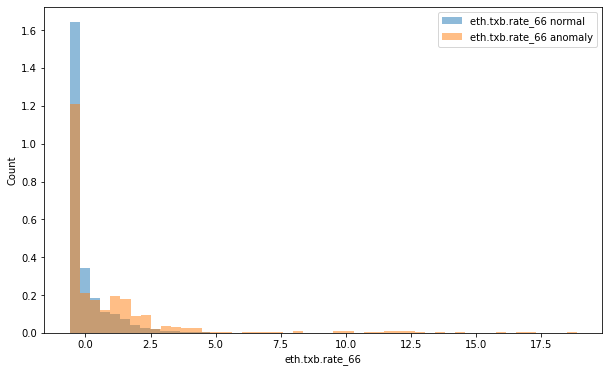

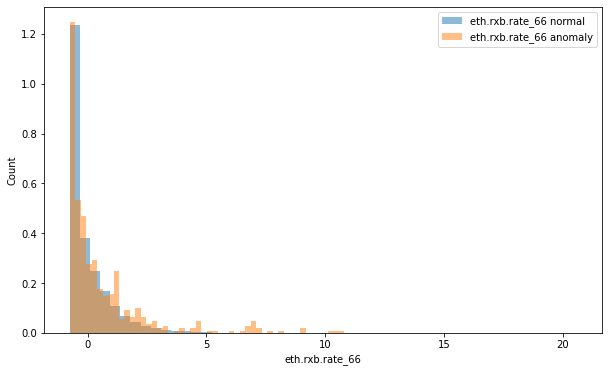

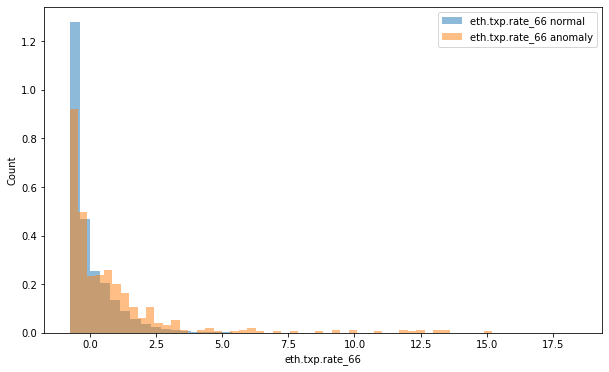

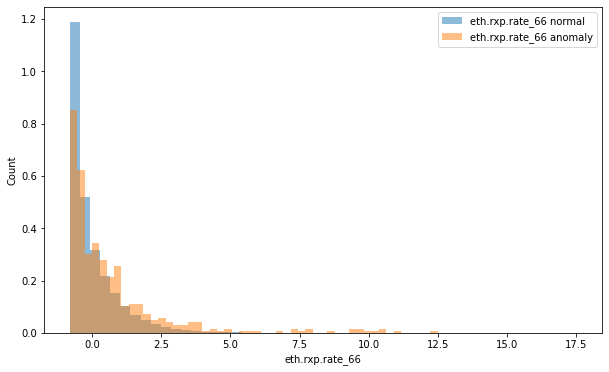

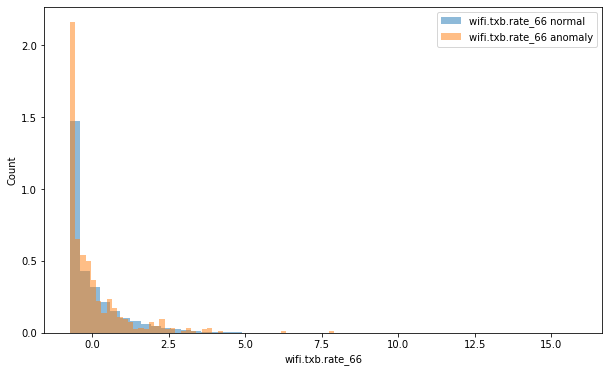

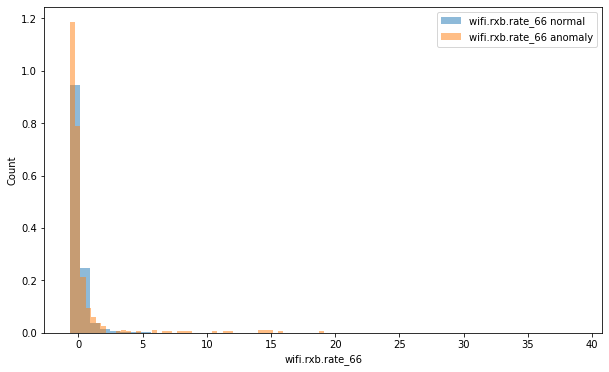

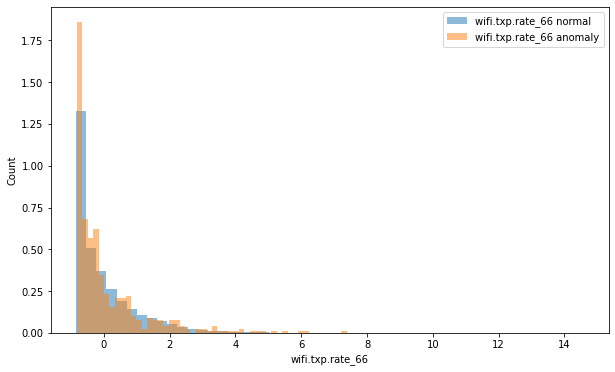

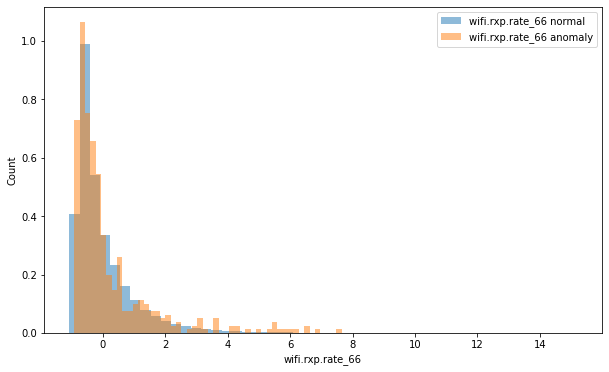

In [15]:
# Feature separability (normalized)
plot_feature_sep(dataset_raw, pred, anomaly_label=-1)

In [16]:
# Define nine outlier detection tools to be compared

# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]
# Parameters
contamination_est = 0.01
random_state = np.random.RandomState(42)
anomaly_label = 1
# random_state  =42
classifiers = {
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=contamination_est),
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=contamination_est,
              check_estimator=False,
              random_state=random_state),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=35),
                       contamination=contamination_est,
                       random_state=random_state,
                       n_jobs=-1),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=contamination_est),
    'Isolation Forest': IForest(contamination=contamination_est,
                                random_state=random_state,
                                n_jobs=-1),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=contamination_est),
    'Average KNN': KNN(method='mean',
                       contamination=contamination_est,
                       n_jobs=-1),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=contamination_est,
            n_jobs=-1),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=contamination_est,
        random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=contamination_est),
    'Locally Selective Combination (LSCP)': LSCP(
        detector_list,
        contamination=contamination_est,
        random_state=random_state),
}
# Show all detectors
for i, clf in enumerate(classifiers.keys()):
    print('Model', i + 1, clf)


Model 1 Angle-based Outlier Detector (ABOD)
Model 2 Cluster-based Local Outlier Factor (CBLOF)
Model 3 Feature Bagging
Model 4 Histogram-base Outlier Detection (HBOS)
Model 5 Isolation Forest
Model 6 K Nearest Neighbors (KNN)
Model 7 Average KNN
Model 8 Local Outlier Factor (LOF)
Model 9 Minimum Covariance Determinant (MCD)
Model 10 One-class SVM (OCSVM)
Model 11 Locally Selective Combination (LSCP)


In [ ]:
#Preprocess dataset
# dataset_cmp = dataset_raw
import time
# Fit the models with the GUIFI data and
print("="*15)
for i, (clf_name, clf) in enumerate(classifiers.items()):
    start_training_time = time.time()
    print(i + 1, 'fitting', clf_name)
    clf_clone = clone(clf_if)
    clf.fit(dataset_raw)
    stop_training_time = time.time() - start_training_time
    print("Completed {} training in:  {}".format(clf_name, stop_training_time))
    scores_pred = clf.decision_function(dataset_raw) * -1
    start_prediciton_time = time.time()
    y_pred_n = clf.predict(dataset_raw)
    stop_prediction_time = time.time() - start_prediciton_time
    print("Completed {} prediction in:  {}".format(clf_name, stop_prediction_time))

    transformer = PCA(n_components=2)
    transformer.fit(dataset_raw)
    X_transformed = transformer.transform(dataset_raw)
    print("Initial shape: {}".format(dataset_raw.shape))
    print("PCA data shape: {}".format(X_transformed.shape))

    dataset_cmp  = X_transformed
    anomaly_index_n = np.where(y_pred_n==1)
    values_n = dataset_cmp[anomaly_index_n]
    print(y_pred_n)
    print("Anomalies in dataset of size {} found: {}".format(len(list(y_pred_n)),list(y_pred_n).count(anomaly_label)))
    # print(values)

    #Plot prediction on 2d
    fig = plt.figure(figsize=(15,15))
    plt.scatter(dataset_cmp[:,0], dataset_cmp[:,1])
    plt.scatter(values_n[:,0], values_n[:,1], color='r', marker='x')
    plt.legend()
    plt.grid()
    plt.title("{} plot with a total of {} anomalies".format(clf_name, list(y_pred_n).count(anomaly_label)))
    plt.show()

    # Decision boundary
    decision_boundary(clf_clone, dataset_cmp, anomaly_label=anomaly_label, model_name="clf_name")


    # Data preprocessing options (3d)
    transformer_3d = PCA(n_components=3)
    transformer_3d.fit(dataset_raw)
    X_transformed_3d_n = transformer_3d.transform(dataset_raw)
    print(X_transformed_3d_n.shape)


    # Plot 3D anomaly map
    fig = plt.figure(figsize=(15,15))

    ax = fig.add_subplot(111, projection='3d')
    ax.set_zlabel("x_composite_3")
    # Plot the compressed data points
    ax.scatter(X_transformed_3d_n[:, 0], X_transformed_3d_n[:, 1], zs=X_transformed_3d_n[:, 2], s=4, lw=1, label="normal",c="blue")
    # Plot x's for the ground truth outliers
    ax.scatter(X_transformed_3d_n[anomaly_index_n,0],X_transformed_3d_n[anomaly_index_n,1], X_transformed_3d_n[anomaly_index_n,2],
               lw=2, s=60, marker="x", c="red", label="anomalies")
    ax.legend()
    plt.title("{} 3D plot with a total of {} anomalies".format(clf_name, list(y_pred_n).count(anomaly_label)))
    plt.show()
    print("="*15)

1 fitting Angle-based Outlier Detector (ABOD)
Completed Angle-based Outlier Detector (ABOD) training in:  466.7805631160736
